# Digital Marketing Analytics - Yelp Challenge 2016

In [1]:
import re,json,ftfy,nltk,pycountry,random,seaborn
import numpy as np
import pandas as pd
import collections as cllt
import sklearn as sk
import matplotlib.pyplot as plt

from nltk import word_tokenize
from os import path
from glob import glob
from scipy.misc import imread
from textblob import TextBlob
from wordcloud import WordCloud
from IPython.display import display, HTML
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

/Users/siangyanglau/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## 1. Executive Summary

### 1.1 Goals and Introduction

You work for a large corporation that owns a collection of restaurants of different types. Currently it is evaluating the location, type, and characteristics (cuisine, price point, design, marketing strategy) and positioning of a new restaurant in Edinburgh (if you know the local habits, you can give better insight). 

Your task is to analyse the dataset and give recommendations on strategy, based on the reviews, location (either neighbourhood or zipcode level) and competition. Also estimates on volumes and revenues of the potential undertaking. You may have to check out what the price-range attributes signify by visiting the Yelp website. 

### 1.2 Methodology

## 2. Analysis - Location and Competition (Kane)

## 3. Analysis - Type and Characteristics (CK)

## 4. Analysis - Review (Siang)

### 4.0 Introduction

The goal of this analysis is to point out demand and preference of customers from a large amount of reviews, with high dimensionality. These topics can provide meaningful insights to opening a new restaurant by considering what customers care about in order to increase the Yelp ratings, which directly affects the revenue. But how can restaurant understand the demands of its customers from a large amount of reviews? For a relatively small collection of reviews, it may be possible to manually inspect and classify the contents of reviews into specific categories based on similarity. But to partition large volumes of text, the process would be extremely time consuming. Topic modelling greatly reduces the time needed to perform the classification and understand the actual contents. We hope to use topic modelling to identify what users care about most when giving their rating stars, and ultimately determine what a new restaurant should be doing in order to receive high ratings.

In this study, I applied a non-negative matrix factorization (NMF) approach for the extraction and detection of concepts or topics from reviews. NMF introduces a technique that simultaneously perform dimension reduction and clustering that identifies semantic features in a document collection and groups the documents into clusters on the basis of shared semantic features [1]. The extracted topics from 1-star and 2-star reviews were used as an indicator of bad practice whereas extracted topics from 4-star and 5-star reviews were used as an indicator of good practice for operating a restaurant.

### 4.1 Description of datasets

Import the datasets.

In [2]:
business = pd.read_csv("edinburgh.csv",header=0)
checkin = pd.read_csv("edinCheckin.csv",header=0)
review = pd.read_csv("edinReview.csv",header=0)
tip = pd.read_csv("edinTip.csv",header=0)
user = pd.read_csv("edinUser.csv",header=0,usecols=range(0,23))

The main dataset in this study was 'yelp_academic_dataset_review.json' and summary of the dataset is shown below.

In [3]:
# Replace nan with blank space
review=review.replace(np.nan,' ', regex=True)

# Summary of dataset
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14290 entries, 0 to 14289
Data columns (total 11 columns):
Unnamed: 0      14290 non-null int64
business_id     14290 non-null object
date            14290 non-null object
review_id       14290 non-null object
stars           14290 non-null object
text            14290 non-null object
type            14290 non-null object
user_id         14290 non-null object
votes_cool      14290 non-null object
votes_funny     14290 non-null object
votes_useful    14290 non-null object
dtypes: int64(1), object(10)
memory usage: 1.2+ MB


In [4]:
review.head(3)

Unnamed: 0             business_id        date               review_id  \
0           0  aFVO6hoFlOCN8pKsmJbWjw  2009-11-14  jnsG2mFZlgdU4tPXFOnsNA   
1           1  aFVO6hoFlOCN8pKsmJbWjw  2010-05-02  dj6XxV1N2AAbifYXhfkUtQ   
2           2  aFVO6hoFlOCN8pKsmJbWjw  2010-05-12  TzqdPoa7Y5Fek6MOMdaV2w   

  stars                                               text    type  \
0     4  I had a pretty good experience at the Doric.  ...  review   
1     2  Whenever the train I'm meant to be getting in ...  review   
2     3  The Doric is apparently "Edinburgh's oldest ga...  review   

                  user_id votes_cool votes_funny votes_useful  
0  o9t7nO4hUiP88FQ_WEvdOw          1           0            0  
1  -ZOyUKJ8d30debwzj1FN7g          0           0            0  
2  pAZYqb6OuPjlHF7AeGy6uQ          0           0            0

The text of reviews is full of punctuations, numbers and capital letters, further cleansing of data is required for text analysis.

In [5]:
review.text.head(10)

0    I had a pretty good experience at the Doric.  ...
1    Whenever the train I'm meant to be getting in ...
2    The Doric is apparently "Edinburgh's oldest ga...
3    My dad is obsessed with his Good Food Guides a...
4    For the start of a friend's Stag Event in Edin...
5    The Doric markets itself as Edinburgh's oldest...
6    This is a good alternative to the fast food/sn...
7    Amazing Sunday Roast dinner!\n\nI saw The Dori...
8    The original building was constructed in the 1...
9    Great fish and chips and shepards pie.  Nice d...
Name: text, dtype: object

### 4.2 Data Cleansing

Clean up the text in review dataset

In [6]:
# Referenced Regular Expression for email cleanup idea: 
def cleanup(text):

    # Make text lower case
    for f in re.findall("([A-Z]+)", text):
        text = text.replace(f, f.lower())
    
    # Remove escape symbols
    text = text.replace('\r', " ")
    text = text.replace('\n', " ")
    
    # Remove all non-ascii characters in the string
    text=unicode(text, 'ascii', 'ignore')

    # Creata a list of reg tools
    cleanuptools = [
    # Dates
    r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)",
    # Removing months
    r"january|february|march|april|may|june|july|august|september|october|november|december",
    # Punctuation and numbers to be removed
    r'[-|.|?|!|,|"|:|;|()|0-9]',
    ]
    
    for tool in cleanuptools:
        text = re.sub(tool," ", text)
    return text


# Constructing a list for stopwords 
stopwords = []

# Add scikit-learn's CountVectorizer's stop list to the created list
stopwords = sk.feature_extraction.text.ENGLISH_STOP_WORDS

In [7]:
# Apply the created functions to clean up text
review.text=review.text.apply(cleanup)

# Cleaned text
review.text[28]

u"this is one of my favourite finds in the city   and what a find   hidden away in the depths of charlotte square  this place doesn't look like much  it's got such a lovely  authentic atmosphere though  really genuine and comforting   it's really traditional and a great place to come if you would like a relaxing  authentic atmosphere   yes it's a bit cave like  but it's an experience  when you go  which you will  you won't be disappointed  and you'll be back  alongside arnold "

### 4.3 Inspection of review contents 

It is crucial to only include reviews with a considerable amount of contents as the topic modelling will not be able to extract any insight from a short review. The length of reviews was therefore analysed and a minimum requirement on the length of review was implemented.

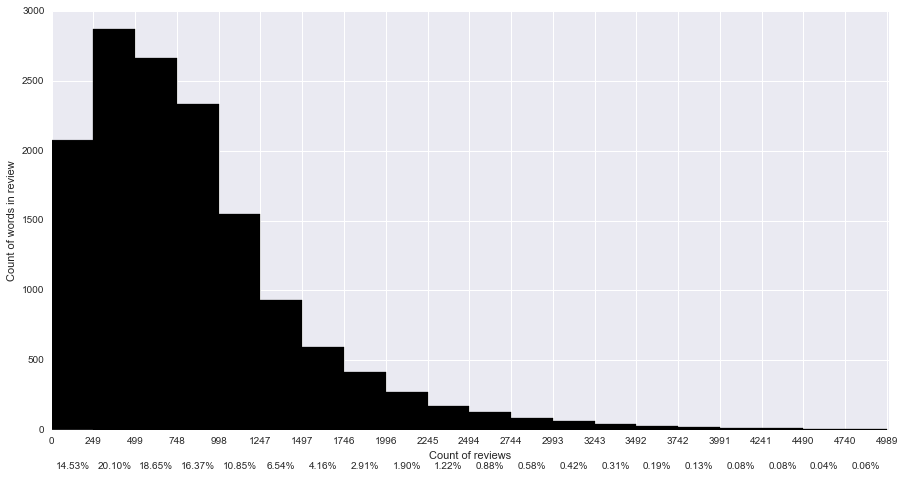

In [8]:
f, ax = plt.subplots(figsize=(15,7.5))
n, bins, patches = ax.hist(review.text.apply(len),facecolor='black',bins=20)
ax.set_xticks(bins)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(n, bin_centers):
    percent = '{:.2f}%'.format((float(count) / n.sum())*100)
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
    xytext=(0, -32), textcoords='offset points', va='top', ha='center')
ax.set_xlabel('Count of reviews')
ax.set_ylabel('Count of words in review')

It can be seen that almost 95% of reviews have length of more than 500 words, therefore, it is not necessary to remove any short reviews. The distribution of ratings was also examined to avoid inbalanced datasets.

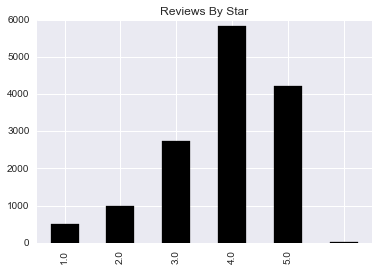

In [9]:
review.stars.value_counts(sort=False).plot(kind='bar',color="black")
plt.title('Reviews By Star');

Inituitively, we thought there would be more 1-star and 5-star reviews, however, the data shows otherwise, and the majority of reviews were 4-star and 5-star. It is also important to check the quality of reviews by examining their numbers of votes.

#### Vote for cool

In [10]:
pd.crosstab(review.stars,review.votes_cool[review.votes_cool!=0],margins=True)

votes_cool   1.0   2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  13.0  \
stars                                                                         
1.0           65     7    1    0    1    0    0    0    0     0     0     0   
2.0          233    38    9    5    0    0    0    0    0     0     0     0   
3.0          755   175   62   19    7    4    1    0    0     0     0     0   
4.0         1862   574  169   68   39   14    8    2    2     2     1     2   
5.0         1284   462  188   96   40   22   10    2    0     2     0     0   
               0     0    0    0    0    0    0    0    0     0     0     0   
All         4199  1256  429  188   87   40   19    4    2     4     1     2   

votes_cool  14.0  15.0  17.0  33.0       All  
stars                                         
1.0            0     0     0     0   0    74  
2.0            0     0     0     0   0   285  
3.0            0     0     0     0   0  1023  
4.0            0     0     0     1   0  2744  
5.0            1     1     1     0   0  2109  
               0     0     0     0  34    34  
All            1     1     1     1  34  6269

#### Vote for funny

In [11]:
pd.crosstab(review.stars,review.votes_funny[review.votes_funny!=0],margins=True)

votes_funny   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  \
stars                                                                         
1.0            59   12    4    1    2    0    0    0    0     0     0     0   
2.0           128   42   11    4    1    2    0    0    0     0     1     0   
3.0           475   97   34   20    3    2    0    2    0     0     0     0   
4.0          1198  265   96   48   14    4    2    1    3     1     1     1   
5.0           820  244  117   53   18    8    1    5    1     0     0     2   
                0    0    0    0    0    0    0    0    0     0     0     0   
All          2680  660  262  126   38   16    3    8    4     1     2     3   

votes_funny  13.0  14.0  19.0  31.0       All  
stars                                          
1.0             0     0     0     0   0    78  
2.0             0     0     0     0   0   189  
3.0             0     0     0     0   0   633  
4.0             0     0     1     1   0  1636  
5.0             1     1     0     0   0  1271  
                0     0     0     0  34    34  
All             1     1     1     1  34  3841

#### Vote for useful

In [12]:
pd.crosstab(review.stars,review.votes_useful[review.votes_useful!=0],margins=True)

votes_useful   1.0   2.0   3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  \
stars                                                                      
1.0            166    71    29   17    2    5    0    0    0     0     0   
2.0            353   165    78   19   13    6    6    1    0     0     0   
3.0            919   428   171   80   35   19    8    2    0     2     0   
4.0           2099   868   394  157   70   52   18    6    5     1     1   
5.0           1412   649   344  158   85   49   24    9    8     5     1   
                 0     0     0    0    0    0    0    0    0     0     0   
All           4949  2181  1016  431  205  131   56   18   13     8     2   

votes_useful  12.0  13.0  15.0  18.0  31.0       All  
stars                                                 
1.0              0     0     0     0     0   0   290  
2.0              0     0     0     0     0   0   641  
3.0              0     0     0     0     0   0  1664  
4.0              1     4     0     0     1   0  3677  
5.0              2     0     1     1     0   0  2748  
                 0     0     0     0     0  34    34  
All              3     4     1     1     1  34  9054

The majority of reviews have only one vote regardless of the type of vote (cool, useful or funny). Originally, we planned to only include reviews with at least two votes. However, by doing so, it would remove a significant amount of text from this analysis. We decided not to remove any reviews based on their numbers of votes.

### 4.4 Methodology and Procedure

### 4.4.1 Dividing dataset

To simplify the classification of topics - Good or Bad reviews. Reviews were split into two groups and 3-star reviews were  excluded in this analysis due to the mixed expression of customers (three stars could be a good or a bad review). First group contains 1-star and 2-star reviews, which were later interpreted as bad reviews and second group contains 4-star and 5-star reviews, which were later interpreted as good reviews. 

In [35]:
# Split the dataset into 2 categories: 1,2 stars and 4,5 stars

review_bad = review[(review.stars == 1) | (review.stars == 2)]
review_good = review[(review.stars == 4) | (review.stars == 5)]

review_good.text.head(10)

0     i had a pretty good experience at the doric   ...
7     amazing   roast dinner   i saw the doric liste...
8     the original building was constructed in the  ...
9     great fish and chips and shepards pie   nice d...
10    doesn't look much from the outside  but this i...
11    i ate a delicious hot smoked scottish salmon p...
12    it's a birthday  and he wants to party like it...
13    passed a delightful evening forking away at my...
14    excellent shepherds pie   the downstairs pub a...
15    amazing atmosphere  amazing food  amazing live...
Name: text, dtype: object

### 4.4.2 Text feature extraction


The text is a sequence of alphabets that cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, a range of functions from python scikit-learn package was used to extract numerical features from text content, namely [1]-[3]:

* **tokenizing** strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.

* **counting** the occurrences of tokens in each document.

* **normalizing** and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms. In order to reduce the influence of terms appearing frequently across the entire corpus, we applied TF-IDF term re-weighting functions to normalize the data. TfidfVectorizer function combines the functions of TF-IDF and vectorization (Vectorization is a process combining tokenizing, counting and normalization) allowing to build a document-term matrix for the corpus of documents: 

In [14]:
#Vectorization
tfidfvectorizer_bad = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), stop_words = stopwords,
                                 strip_accents="unicode", use_idf=True, norm="l2", min_df = 5)
tfidfvectorizer_good = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), stop_words = stopwords,
                                 strip_accents="unicode", use_idf=True, norm="l2", min_df = 5)

#Create term document matrix for separate datasets
term_document_matrix_bad = tfidfvectorizer_bad.fit_transform(review_bad.text)
term_document_matrix_good = tfidfvectorizer_good.fit_transform(review_good.text)

### 4.4.3 Topic Modelling: Non-negative Matrix Factorization (NMF)

In topic modeling, there are several methods for learning abstract topics in a collection of documents. NMF is a new and emerging method of unsupervised learning to discover hidden topics. We applied the scikit-learn implementation of NMF with NNDSVD initialization. Nonnegative Double Singular Value Decomposition (NNDSVD) is typically used for overcoming sparseness of data in document-term matrix [8]. Here I set the number of topics to be equal to 25 and run NMF for 200 iterations, and then get the factors W and H from the resulting model:

In [15]:
# 1-star + 2-star reviews
nmfmodel_bad = sk.decomposition.NMF(init="nndsvd", n_components=25, max_iter=200).fit(term_document_matrix_bad)
W_bad = nmfmodel_bad.fit_transform(term_document_matrix_bad);
H_bad = nmfmodel_bad.components_
# W (number of reviews,number of topics) and H (number of topics, number of features)
print "Generated factor W of size %s and factor H of size %s for bad reviews" \
% ( str(W_bad.shape), str(H_bad.shape) )

# 4-star + 5-star reviews
nmfmodel_good = sk.decomposition.NMF(init="nndsvd", n_components=25, max_iter=200).fit(term_document_matrix_good)
W_good = nmfmodel_good.fit_transform(term_document_matrix_good);
H_good = nmfmodel_good.components_
# W (number of reviews,number of topics) and H (number of topics, number of features)
print "Generated factor W of size %s and factor H of size %s for good reviews" \
% ( str(W_good.shape), str(H_good.shape) )

Generated factor W of size (1492, 25) and factor H of size (25, 3795) for bad reviews
Generated factor W of size (10026, 25) and factor H of size (25, 15000) for good reviews


### 4.5 Results

### 4.5.1 Writting function for presenting results

Writting a range of functions to plot graphs to present the top topics discovered by NMF model.

In [16]:
# Create a colour series for graph plotting
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Writting functions to show top words in each topic
def TopTermsByTopic(nmfmodel, features, top):
    for index, topic in enumerate(nmfmodel.components_):
        print "\n Topic {}: \n".format(index+1)
        print "Percentage of Words: {:.2%}\n".format(np.count_nonzero(topic) / 41961.)
        
        top_words = [features[i] for i in nmfmodel.components_[index].argsort()[::-1][:top]]
        topic_words = ' '.join(top_words)

        #Prepare data for horizontal bar charts
        top15_index = nmfmodel.components_[index].argsort()[::-1][:15]
        top15_topic = sorted(topic[top15_index],reverse=False)

        #Prepare data for wordclouds
        wc = WordCloud(max_font_size=80,relative_scaling=.5,width=800,height=500).generate(topic_words)
       
        #Create a space for graphs
        fig, ax = plt.subplots(2,figsize=(12,10))
        rect1 = ax[0].barh(.5 + np.arange(15) + .5, top15_topic, color="black", align="center")
        rect2 = ax[1].imshow(wc.recolor(color_func=grey_color_func, random_state=3))
        
        #Subplot 1 - Horizontal Bar Chart
        ax[0].set_title("Top 15 Terms in Topic {}".format(index + 1))
        ax[0].set_xlabel("Weight")
        ax[0].set_yticks(.5 + np.arange(15)+ .5)
        ax[0].set_yticklabels([features[i] for i in topic.argsort()[::-1][:15]])
        ax[0].grid(True)
        
        #Subplot 2 - WordCloud
        ax[1].axis("off")
        ax[1].set_title("Wordcloud of Topic {}".format(index + 1))
        
        #Show the graphs
        plt.tight_layout()
        plt.show()

Creating a list of features (tokenized words) generated from NMF model.

In [17]:
#Extracting the feature names
features_bad= tfidfvectorizer_bad.get_feature_names()
features_good= tfidfvectorizer_good.get_feature_names()

### 4.5.2 Results - Top Terms by each topic

This section shows the most significant topics discovered by NML model, also, the top 15 highest weighted terms were presented on a horizontal bar chart along with the rest of the terms on a word cloud. Experiments suggests 25 topics are optimal, this number allows a clearer separation of topics. 

** Bad Reviews: 1-star and 2-star reviews**


 Topic 1: 

Percentage of Words: 4.82%



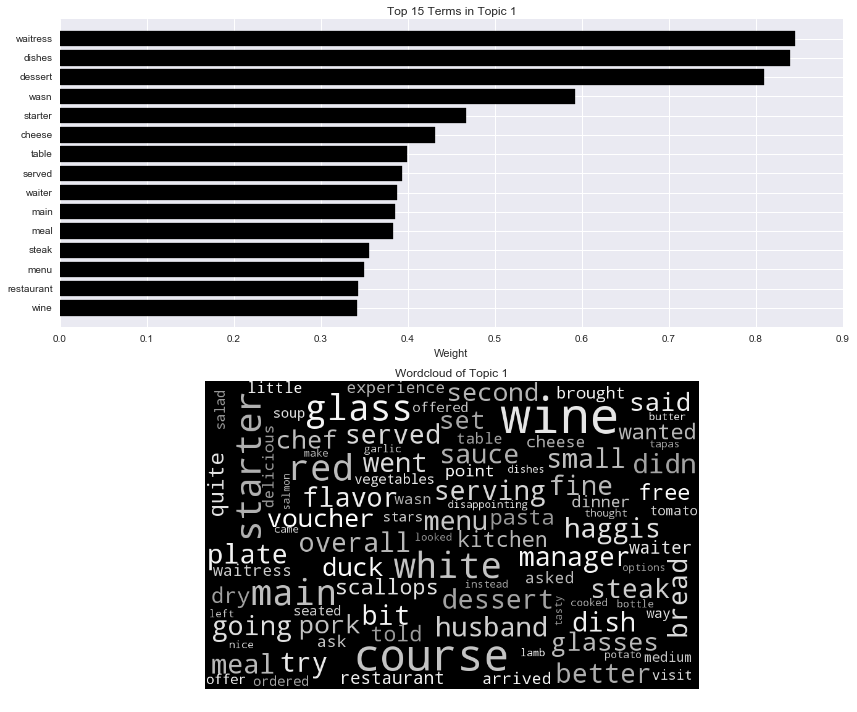


 Topic 2: 

Percentage of Words: 3.02%



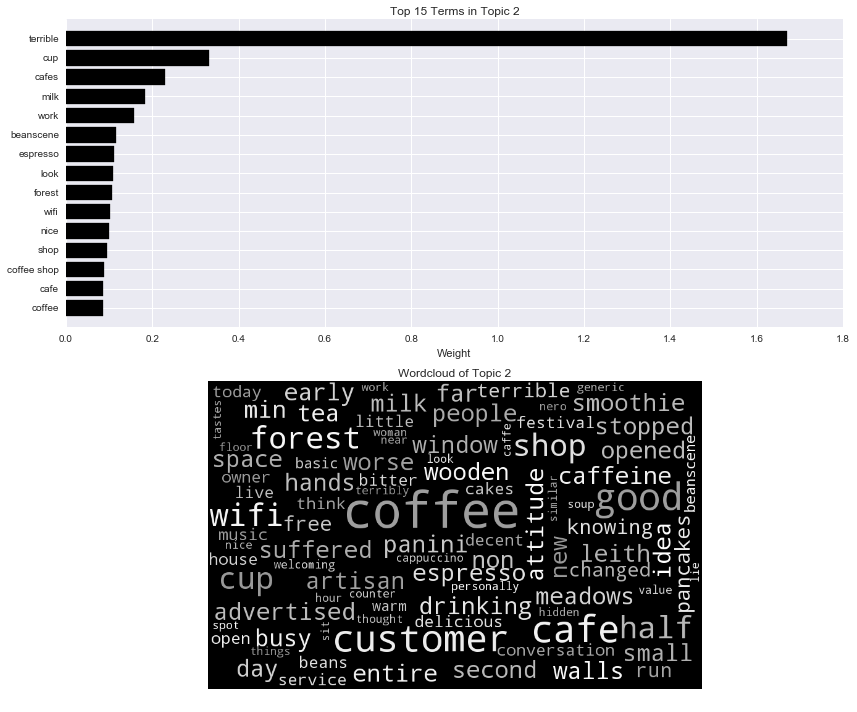


 Topic 3: 

Percentage of Words: 3.44%



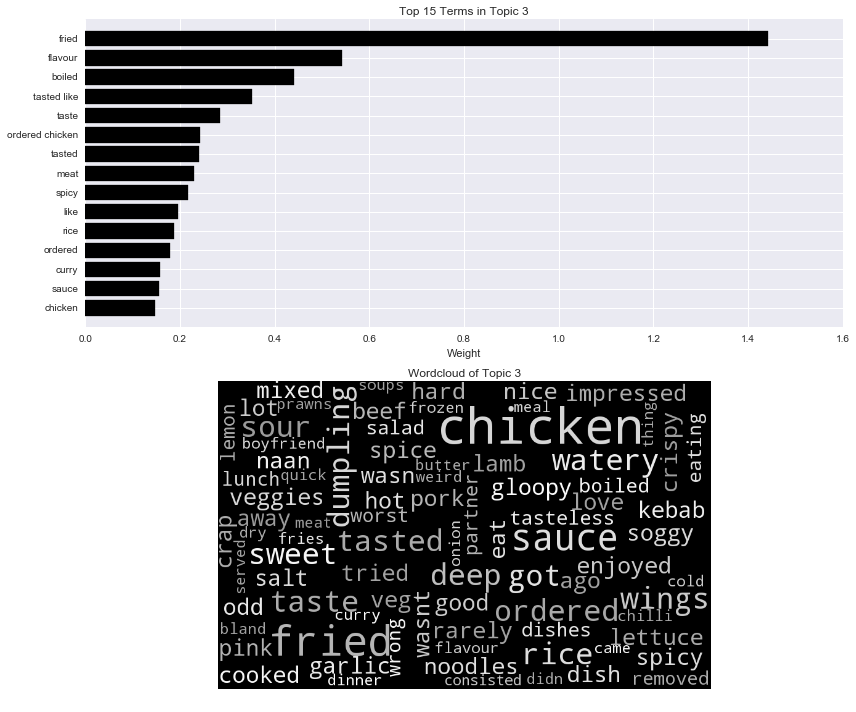


 Topic 4: 

Percentage of Words: 3.28%



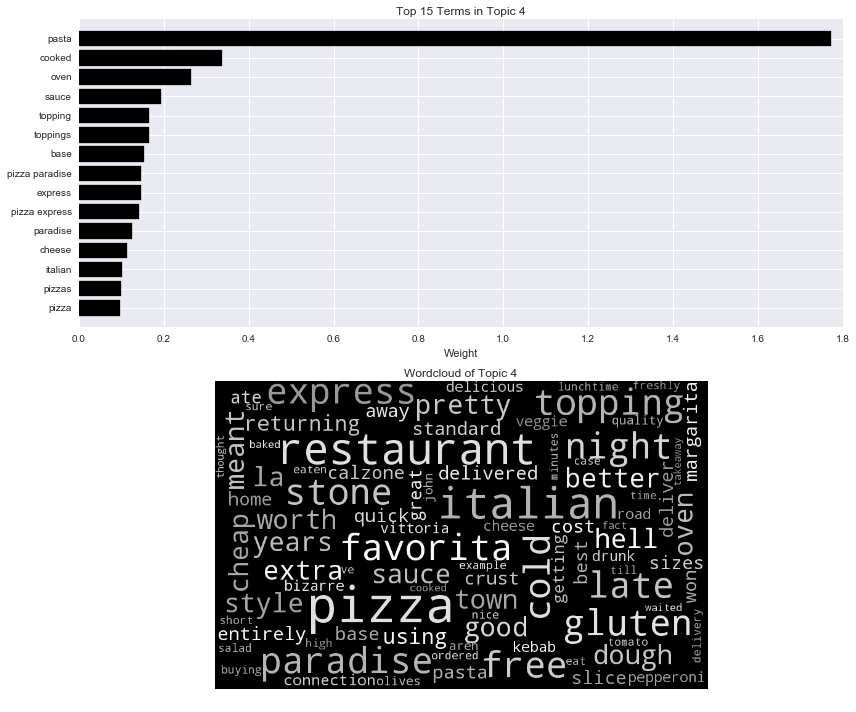


 Topic 5: 

Percentage of Words: 3.34%



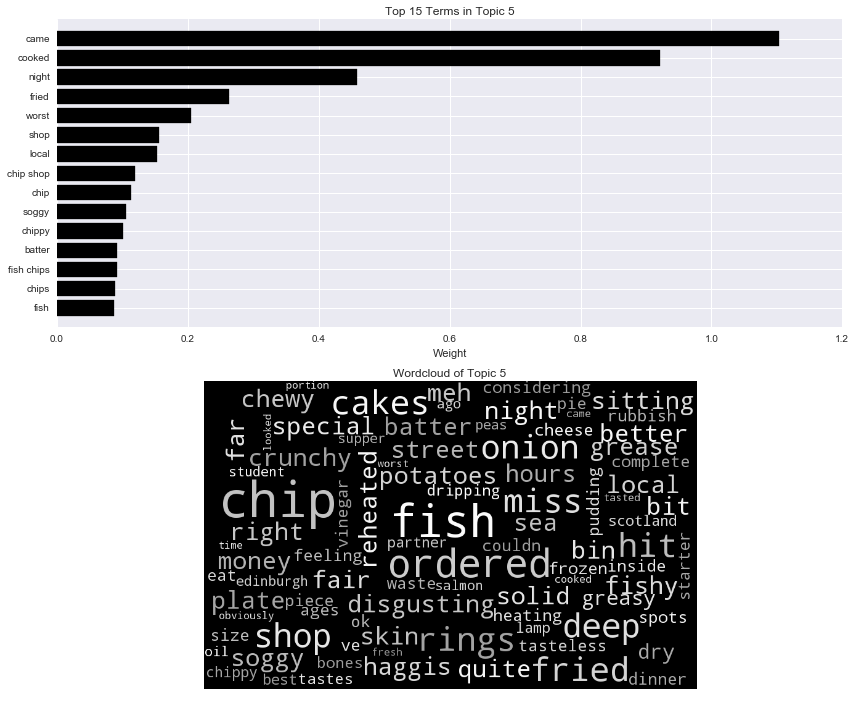


 Topic 6: 

Percentage of Words: 3.35%



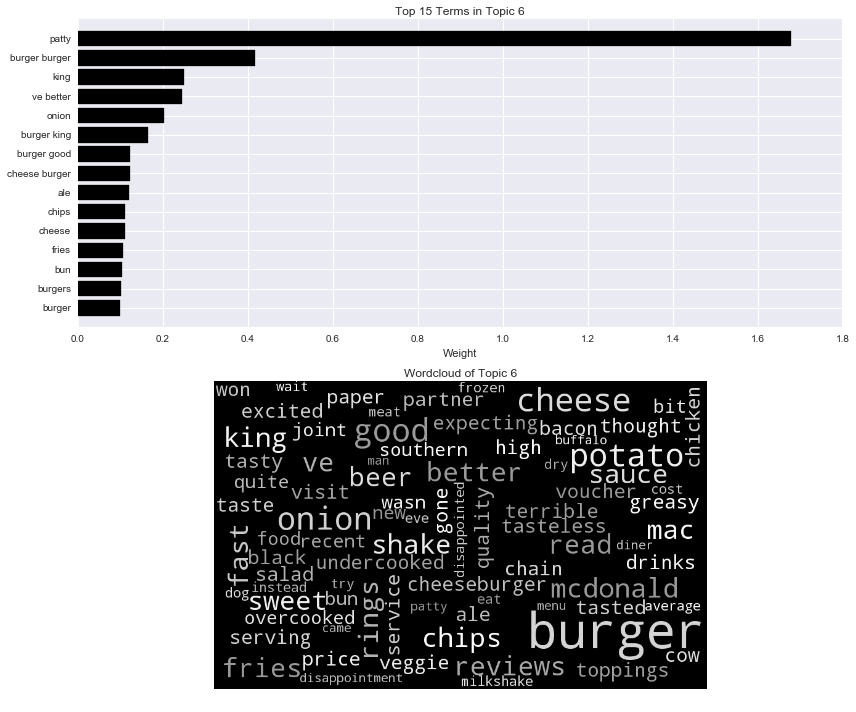


 Topic 7: 

Percentage of Words: 2.96%



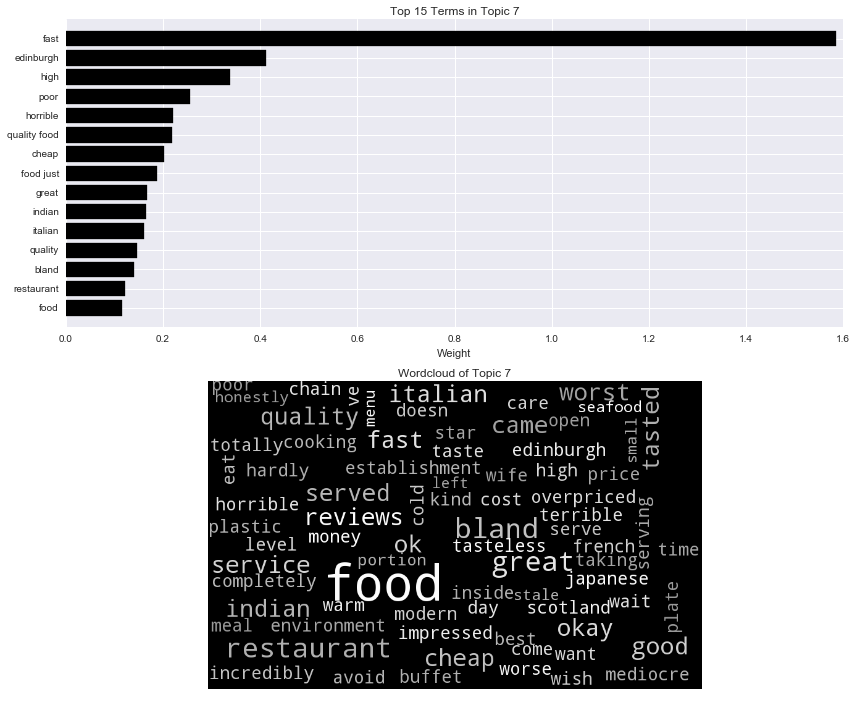


 Topic 8: 

Percentage of Words: 3.93%



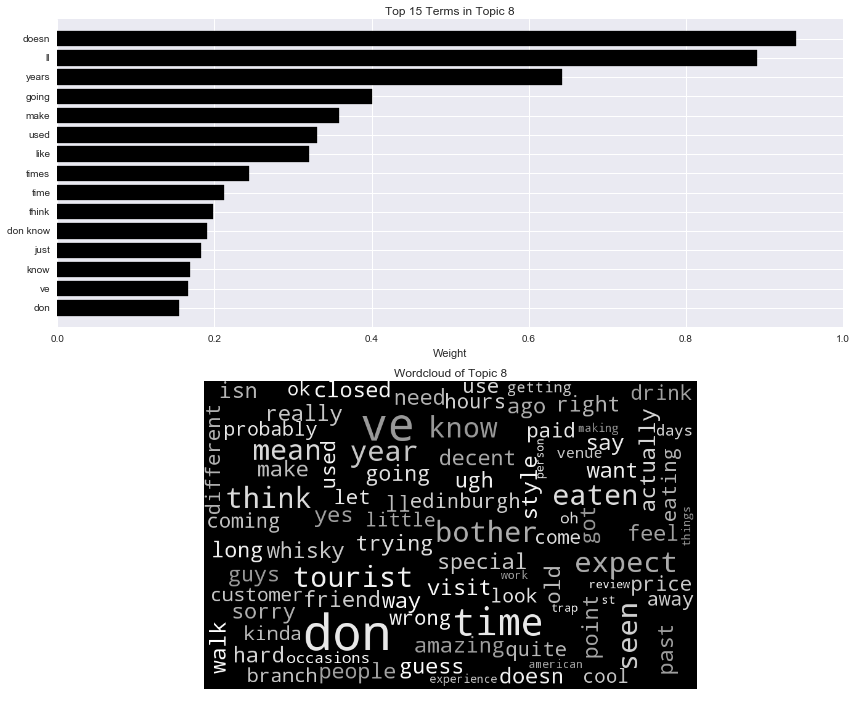


 Topic 9: 

Percentage of Words: 2.51%



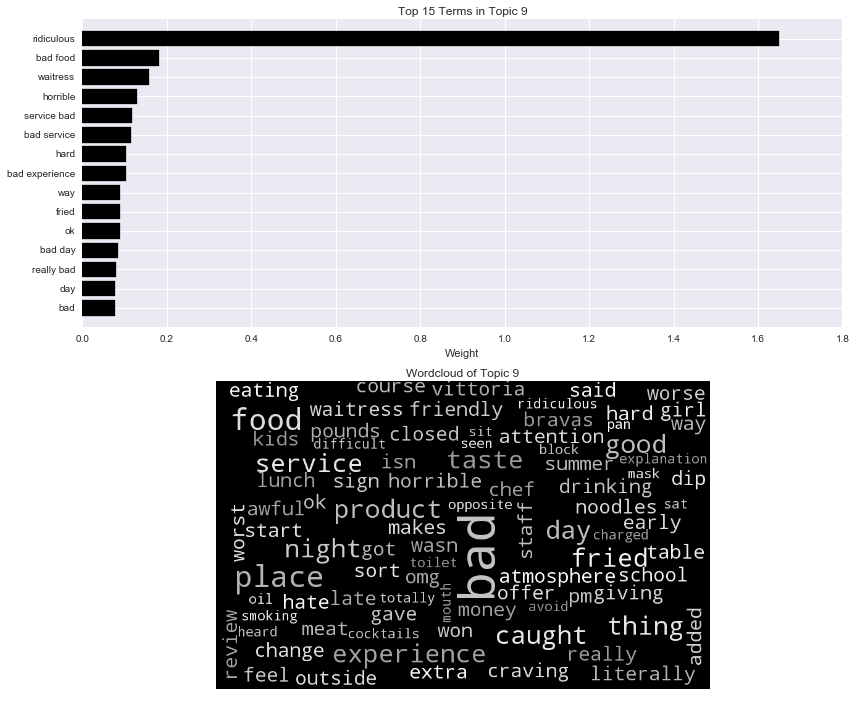


 Topic 10: 

Percentage of Words: 1.88%



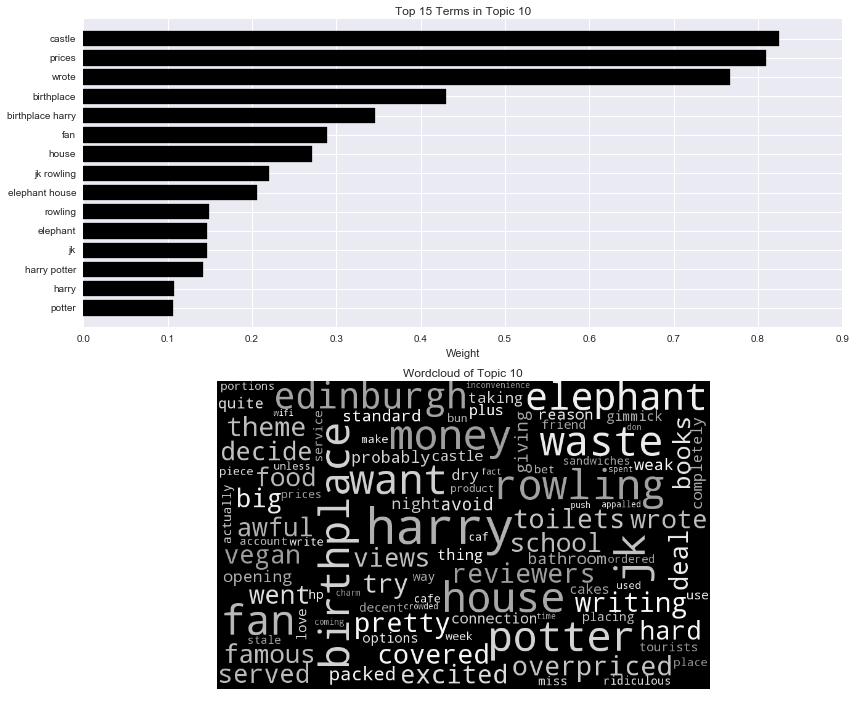


 Topic 11: 

Percentage of Words: 3.72%



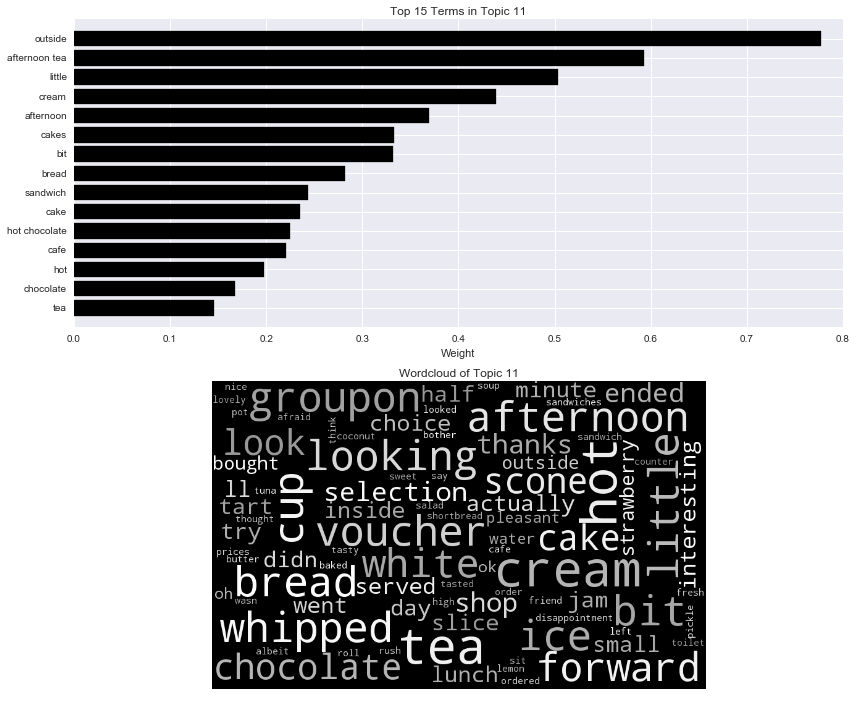


 Topic 12: 

Percentage of Words: 3.04%



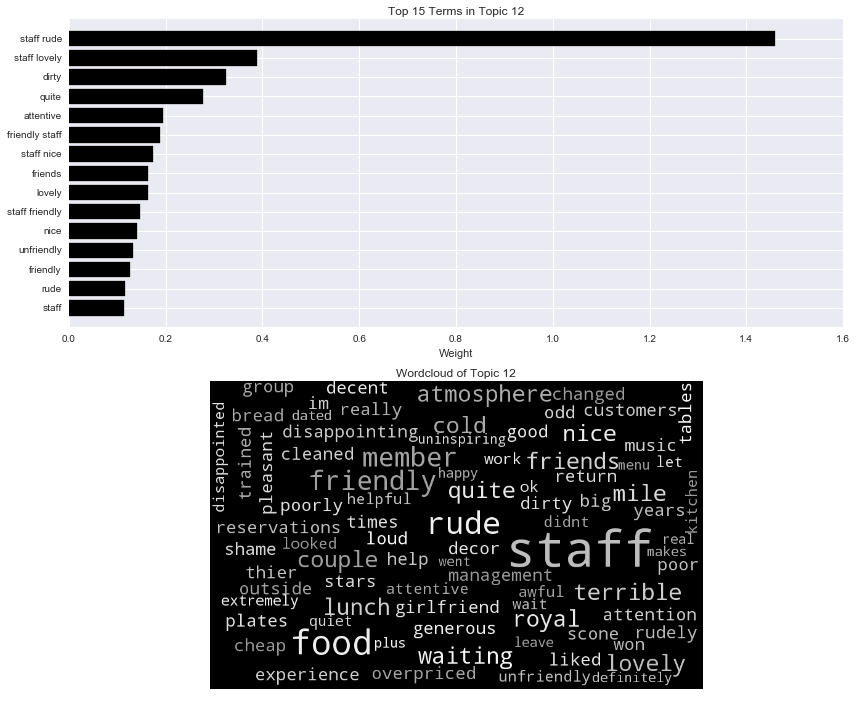


 Topic 13: 

Percentage of Words: 2.77%



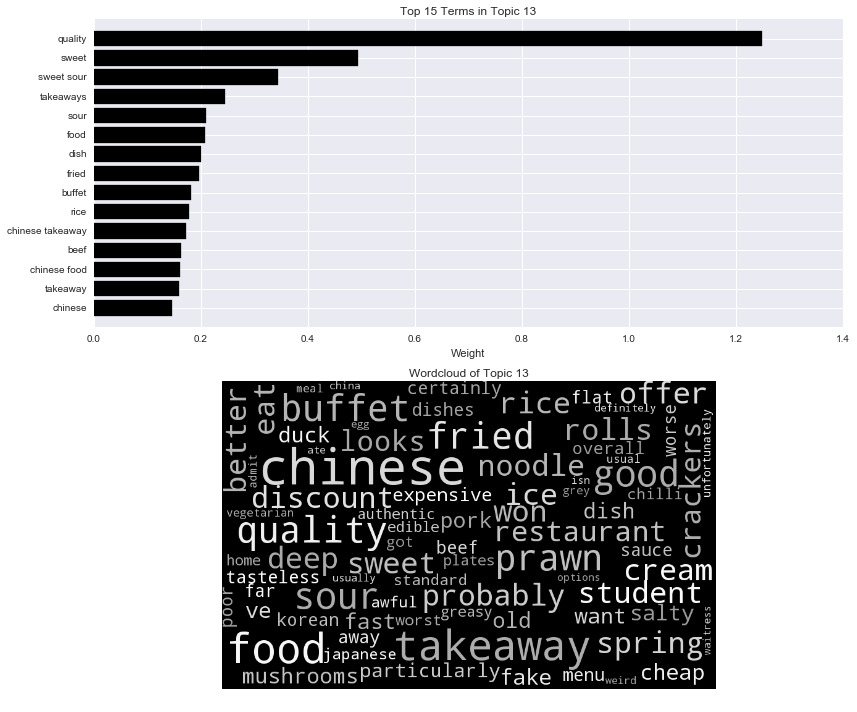


 Topic 14: 

Percentage of Words: 2.23%



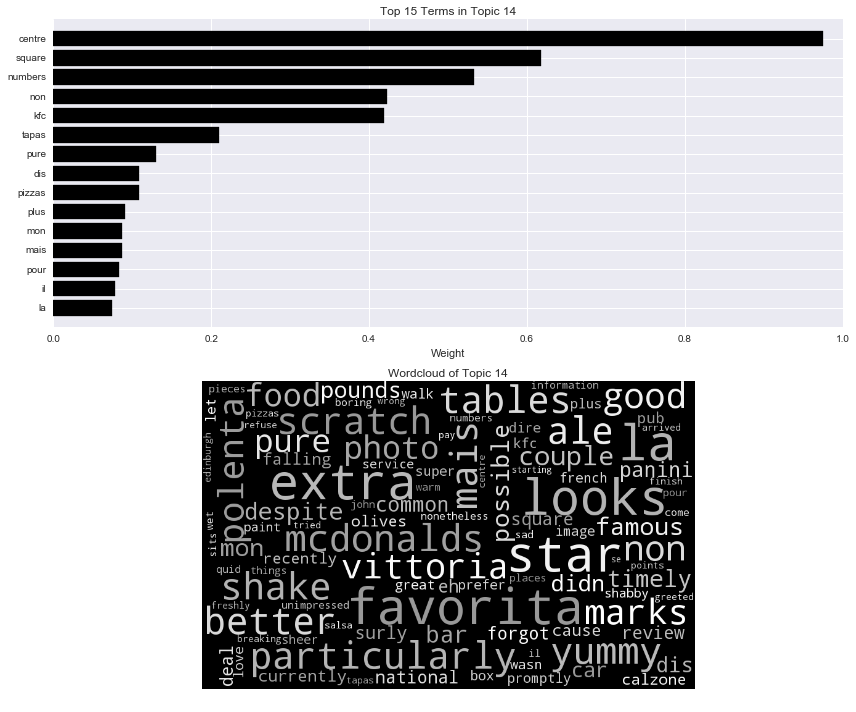


 Topic 15: 

Percentage of Words: 2.91%



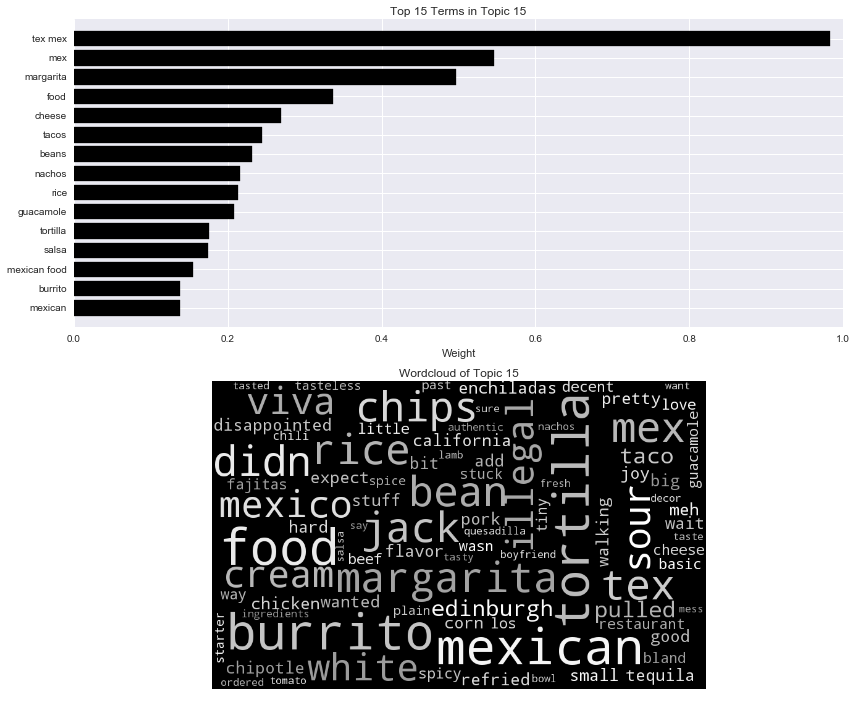


 Topic 16: 

Percentage of Words: 3.37%



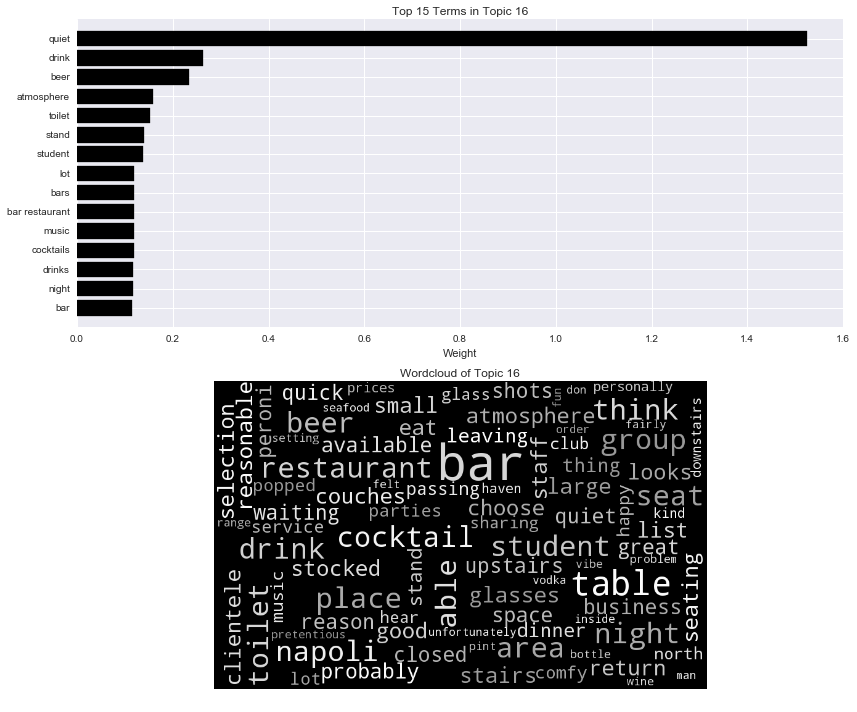


 Topic 17: 

Percentage of Words: 3.18%



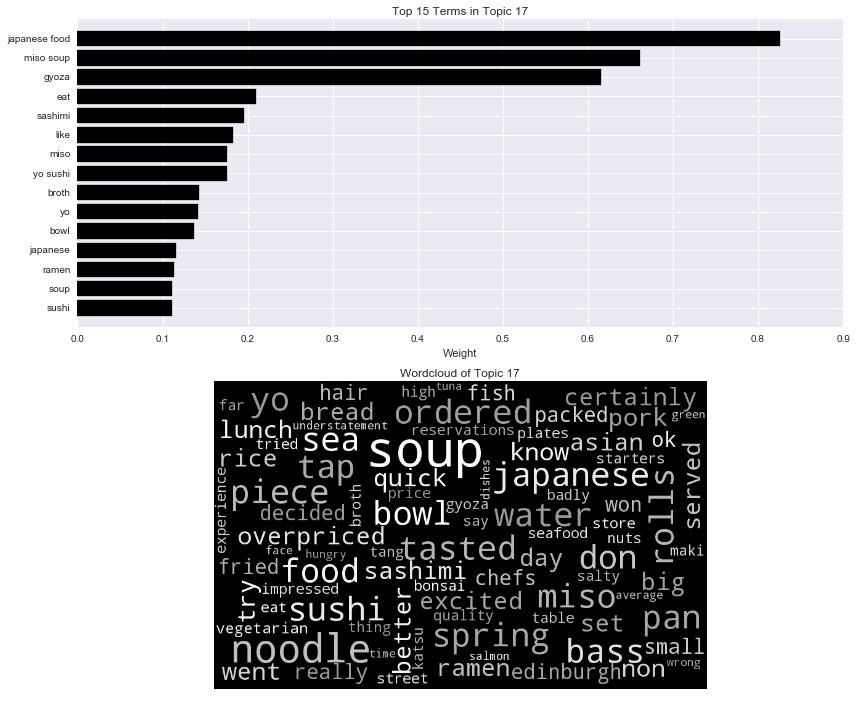


 Topic 18: 

Percentage of Words: 3.67%



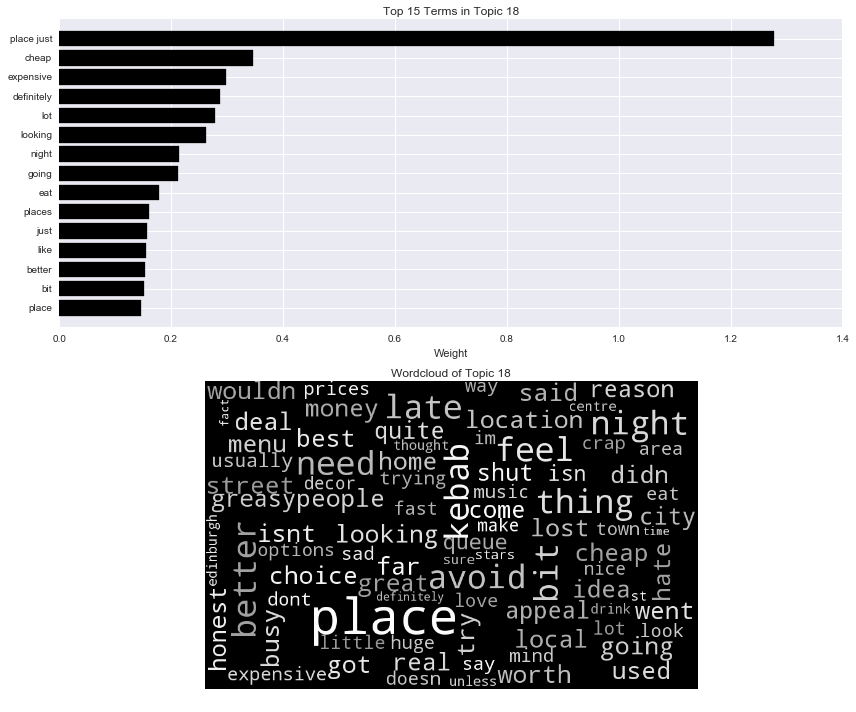


 Topic 19: 

Percentage of Words: 2.79%



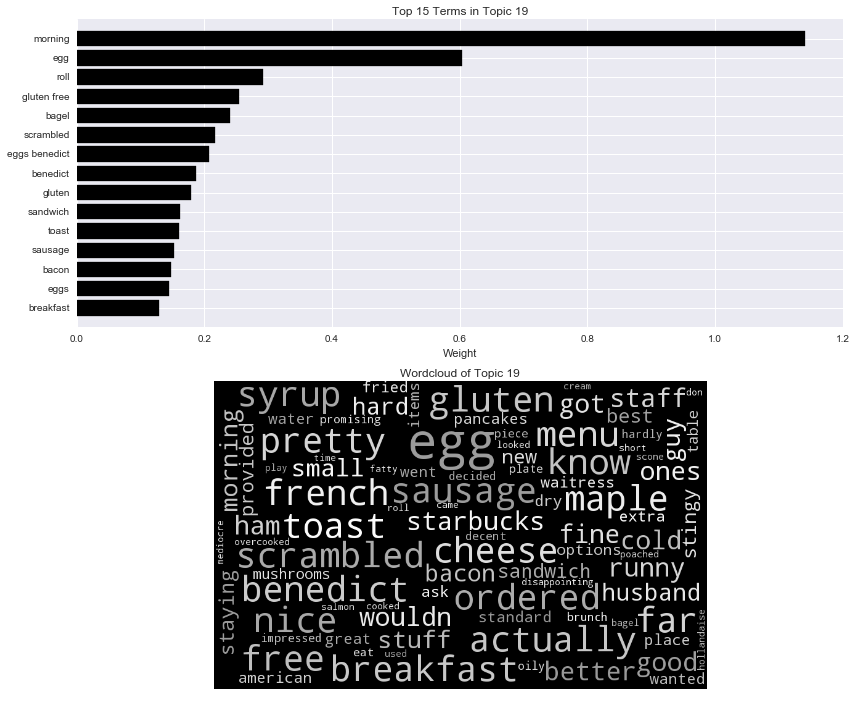


 Topic 20: 

Percentage of Words: 3.99%



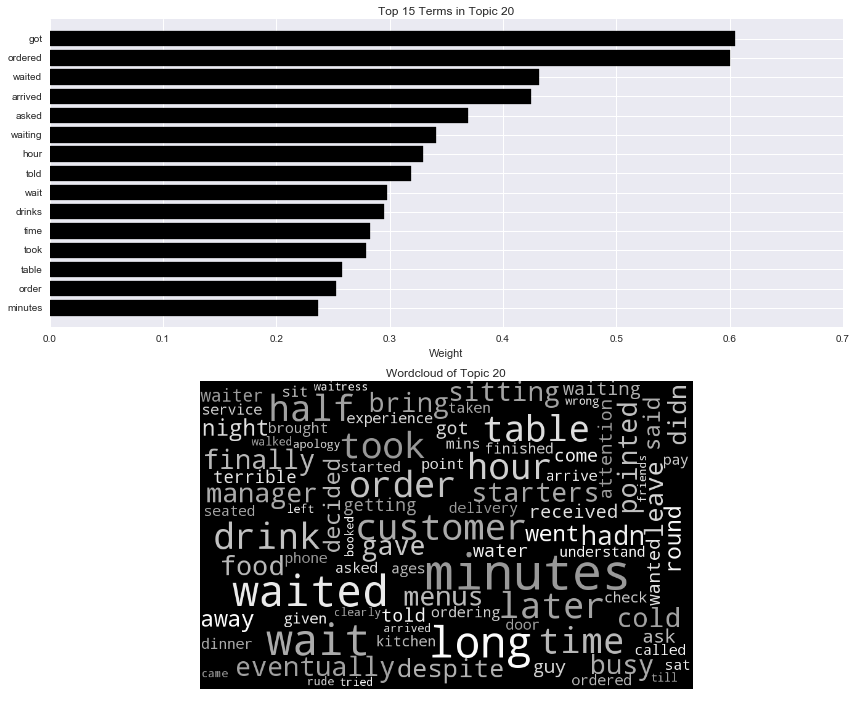


 Topic 21: 

Percentage of Words: 3.41%



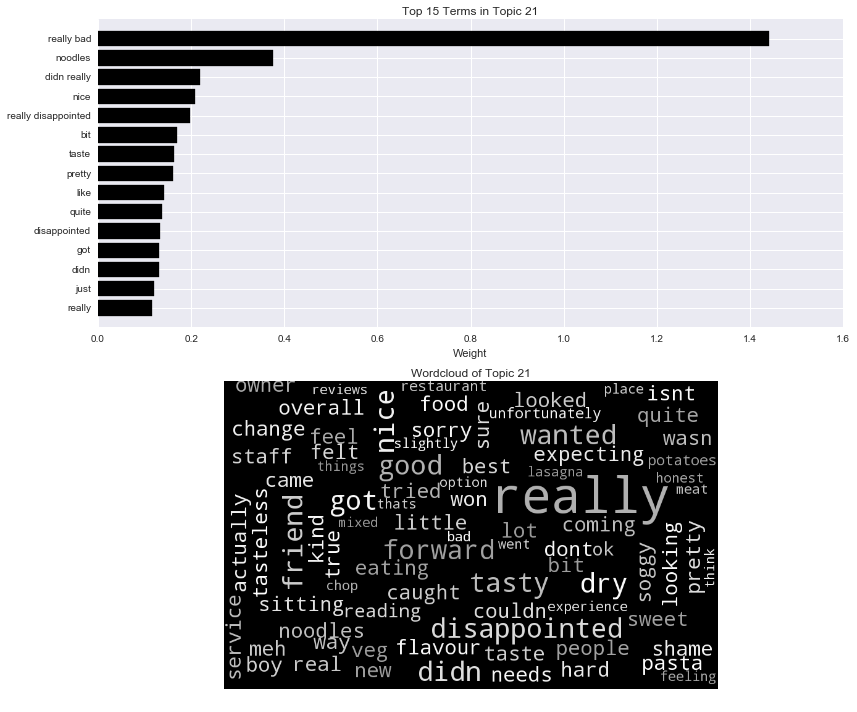


 Topic 22: 

Percentage of Words: 2.83%



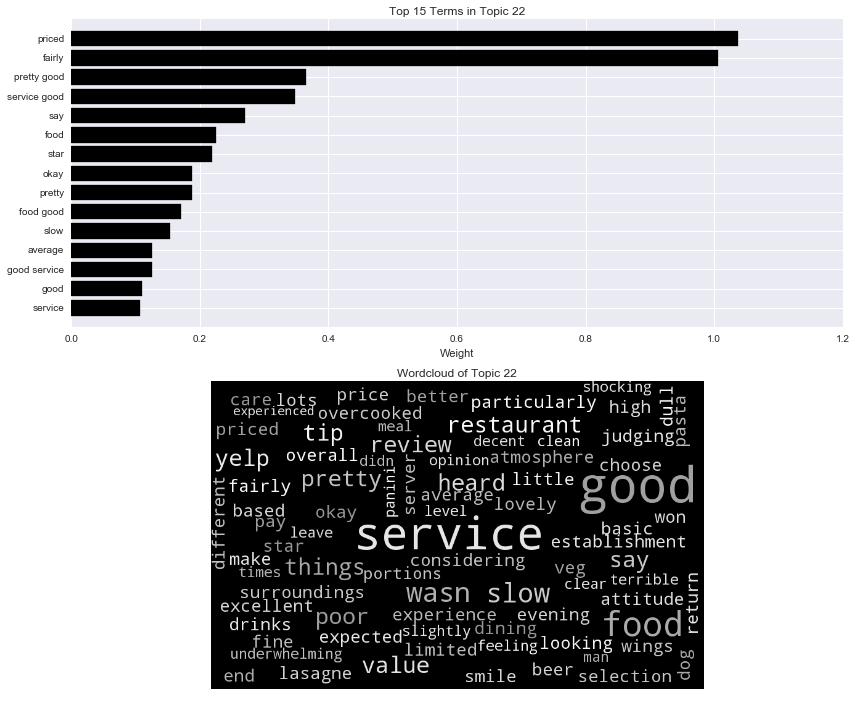


 Topic 23: 

Percentage of Words: 3.07%



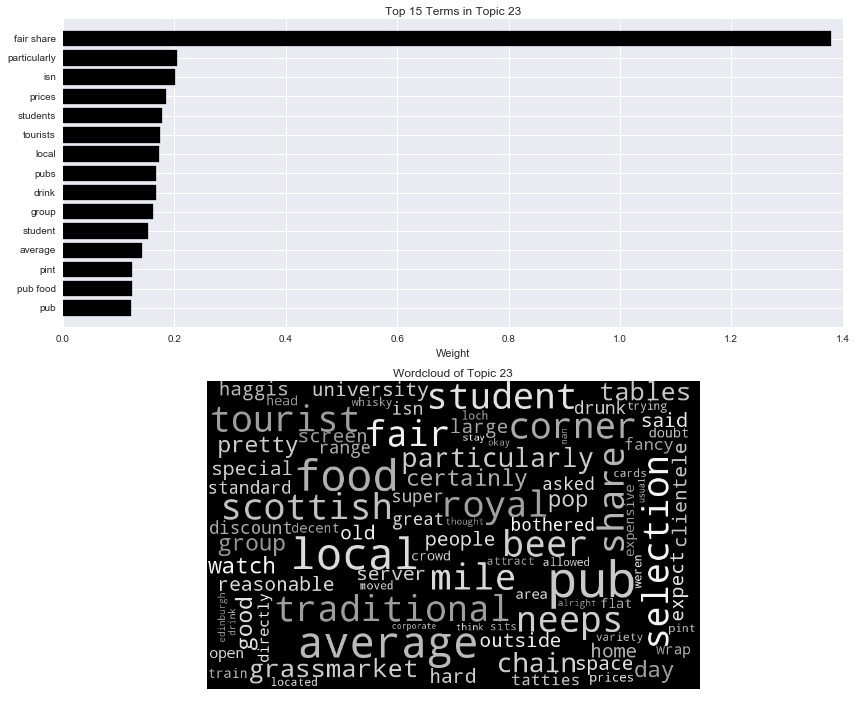


 Topic 24: 

Percentage of Words: 3.08%



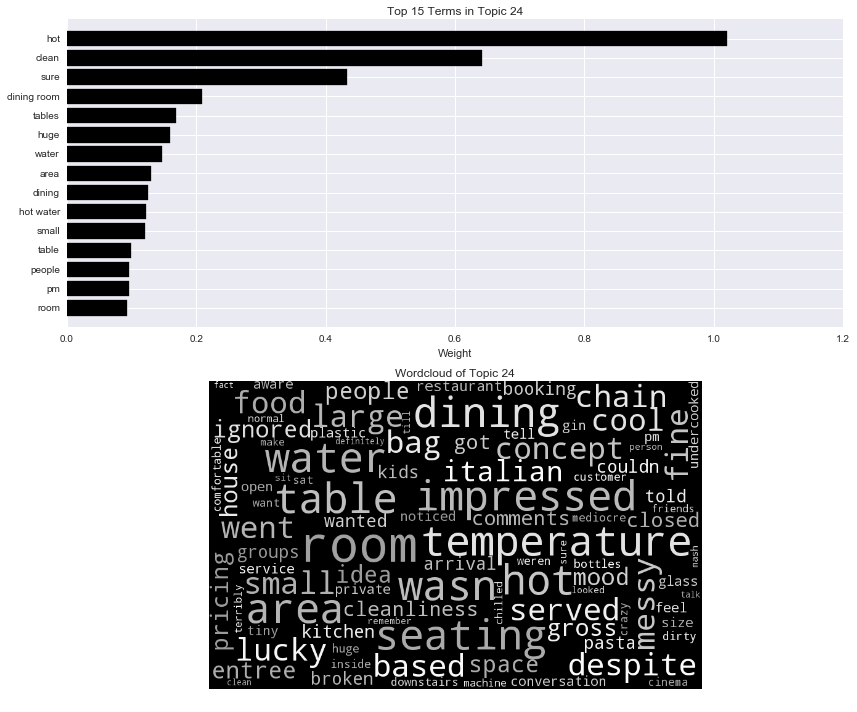


 Topic 25: 

Percentage of Words: 2.72%



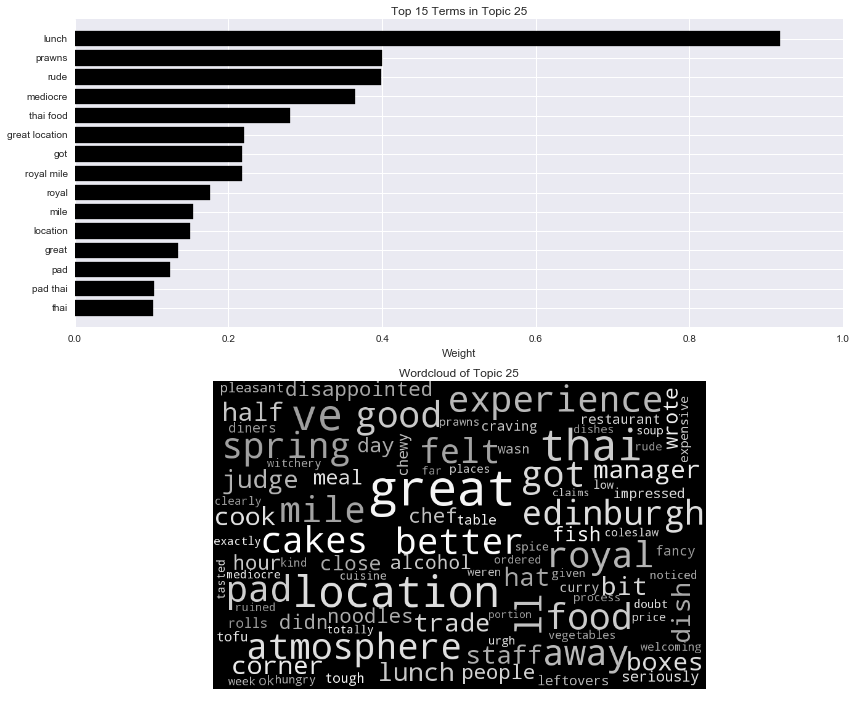

In [18]:
TopTermsByTopic(nmfmodel_bad, features_bad, 100)

This section summarises topics discovered by NMF model from bad reviews text. An attempt to interpret the contents of each topic was made, keywords in each topic were manually examined and a description of each topic was then assigned.

In [38]:
data_bad = {'Index of Topics':['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8'
                           ,'Topic 9','Topic 10','Topic 11','Topic 12','Topic 13','Topic 14','Topic 15'
                           ,'Topic 16','Topic 17','Topic 18','Topic 19','Topic 20',
                            'Topic 21','Topic 22','Topic 23','Topic 24','Topic 25']
        ,'Type of Topics':['Bad service from manager and waiter/waitress ', 'Bad Coffee Shop',
                           'Bad Chicken Dishes (Fried, Boiled, Curry)',
                           'Bad Italian Foods (Pizza and Pasta: Toppings, base, sauce, etc.)',
                           'Bad Fried Chips (Soggy Batter)','Bad Burger', 'Unknown Topic',
                           'Bad wait and time management','Bad Experience and Services',
                           'Bad Restaurant (Birthplace of Harry Potter)','Bad Afternoon Tea',
                           'Unfriendly and Rude Staffs','Bad Chinese Sweet and Sour Foods',
                           'Unknown Topic','Bad Mexican Foods','Bad Place for drinks (too quiet)',
                           'Bad Japanese Foods (Tuna, Miso Soup)','Bad Prices','Bad Breakfast (Eggs Benedict)',
                           'Bad Wait and Time Management','Bad Noodles', 'Good Comments in Bad Reviews',
                           'Expensive Place for Tourists', 'Hot Temperature','Bad Thai Foods'                           
                           ]
       } 

topic_table_bad = pd.DataFrame(data_bad)
display(topic_table_bad)

Index of Topics                                     Type of Topics
0          Topic 1      Bad service from manager and waiter/waitress 
1          Topic 2                                    Bad Coffee Shop
2          Topic 3          Bad Chicken Dishes (Fried, Boiled, Curry)
3          Topic 4  Bad Italian Foods (Pizza and Pasta: Toppings, ...
4          Topic 5                     Bad Fried Chips (Soggy Batter)
5          Topic 6                                         Bad Burger
6          Topic 7                                      Unknown Topic
7          Topic 8                       Bad wait and time management
8          Topic 9                        Bad Experience and Services
9         Topic 10        Bad Restaurant (Birthplace of Harry Potter)
10        Topic 11                                  Bad Afternoon Tea
11        Topic 12                         Unfriendly and Rude Staffs
12        Topic 13                   Bad Chinese Sweet and Sour Foods
13        Topic 14                                      Unknown Topic
14        Topic 15                                  Bad Mexican Foods
15        Topic 16                               Bad Place for drinks
16        Topic 17               Bad Japanese Foods (Tuna, Miso Soup)
17        Topic 18                                         Bad Prices
18        Topic 19                      Bad Breakfast (Eggs Benedict)
19        Topic 20                       Bad Wait and Time Management
20        Topic 21                                        Bad Noodles
21        Topic 22                       Good Comments in Bad Reviews
22        Topic 23                       Expensive Place for Tourists
23        Topic 24                                    Hot Temperature
24        Topic 25                                     Bad Thai Foods

** Good Reviews: 4-star and 5-star reviews**


 Topic 1: 

Percentage of Words: 17.82%



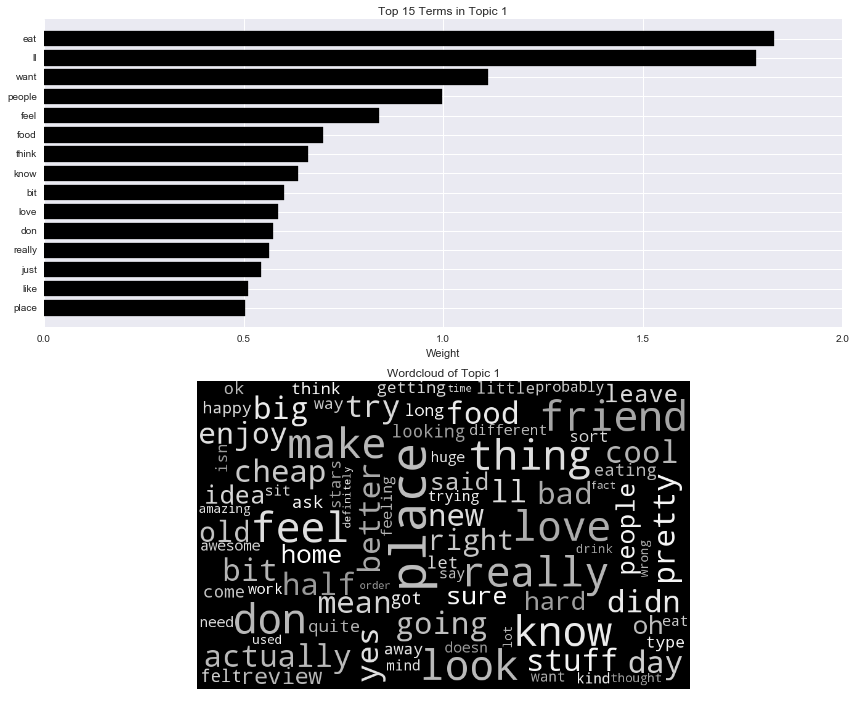


 Topic 2: 

Percentage of Words: 15.70%



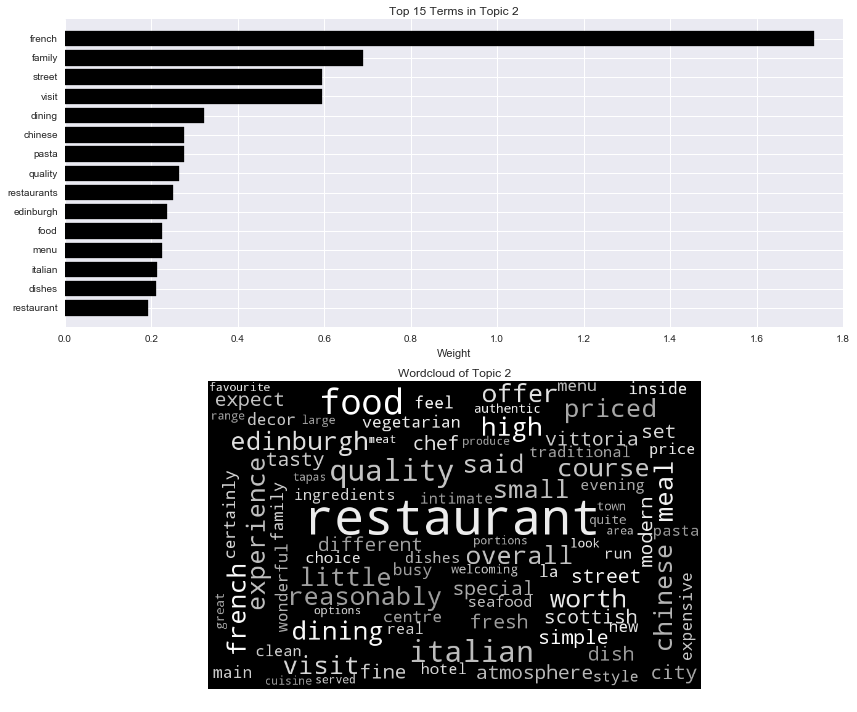


 Topic 3: 

Percentage of Words: 8.38%



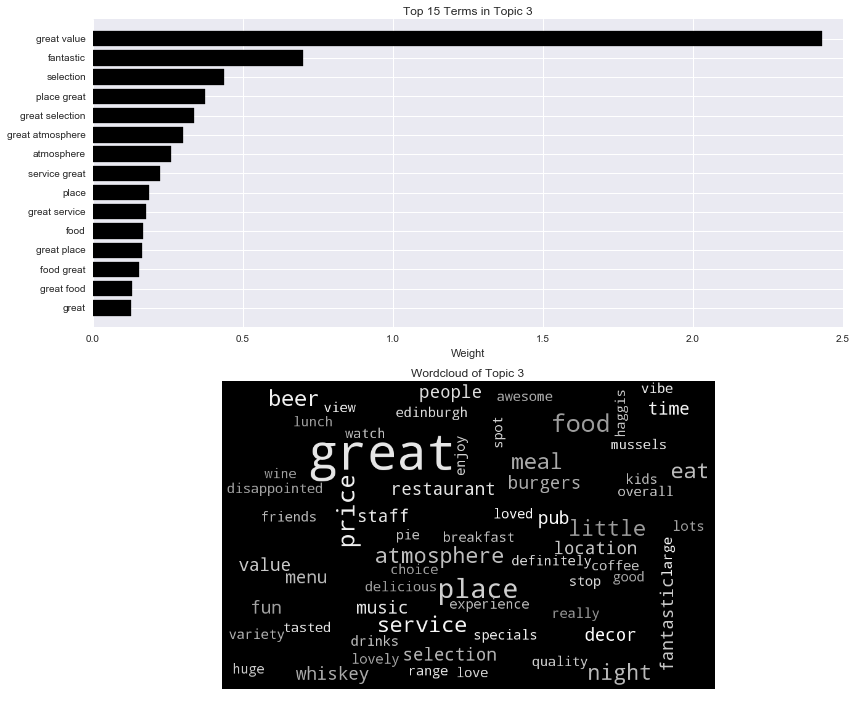


 Topic 4: 

Percentage of Words: 16.57%



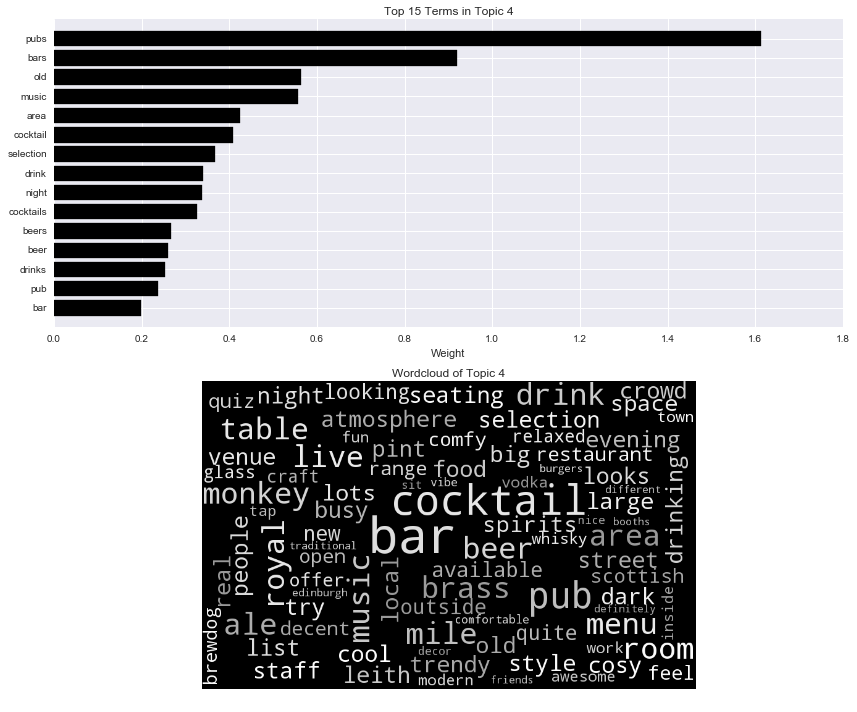


 Topic 5: 

Percentage of Words: 12.17%



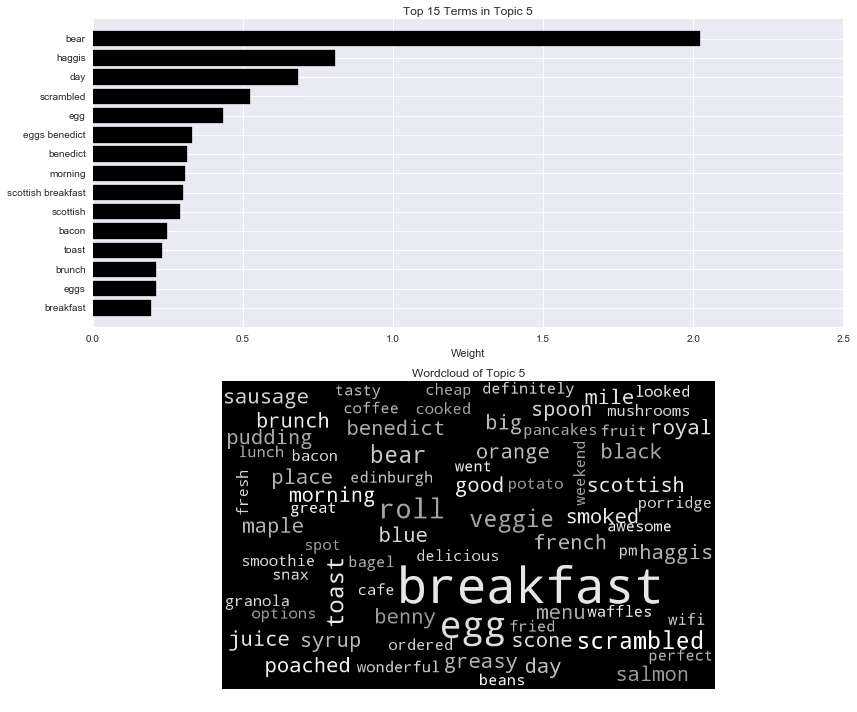


 Topic 6: 

Percentage of Words: 11.20%



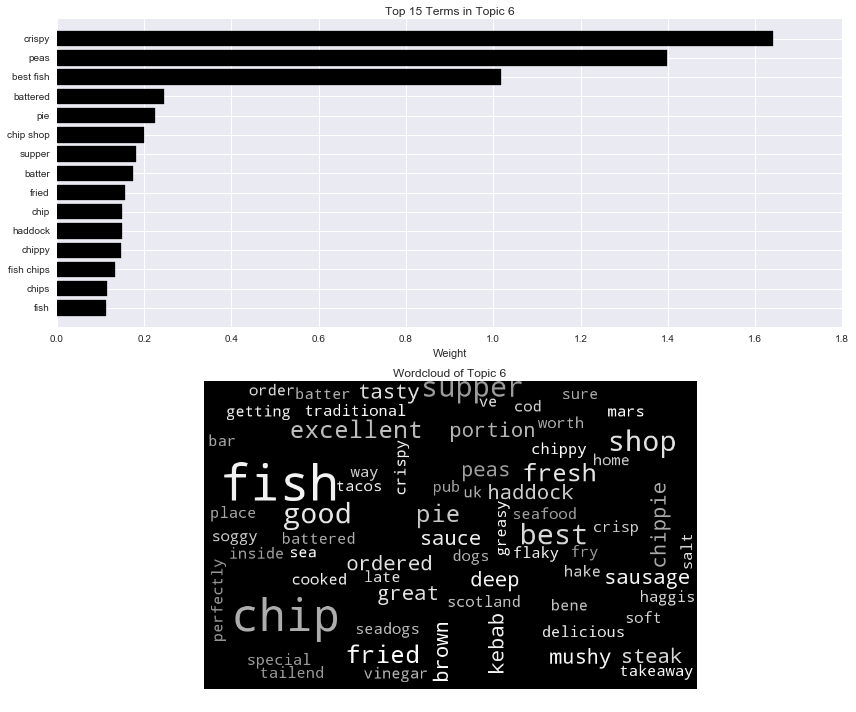


 Topic 7: 

Percentage of Words: 10.43%



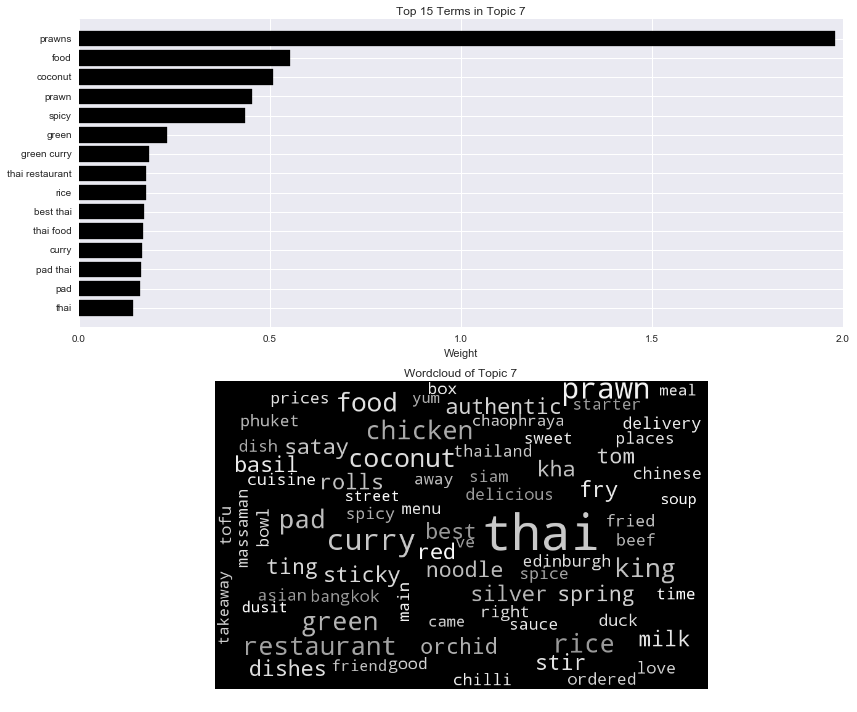


 Topic 8: 

Percentage of Words: 12.76%



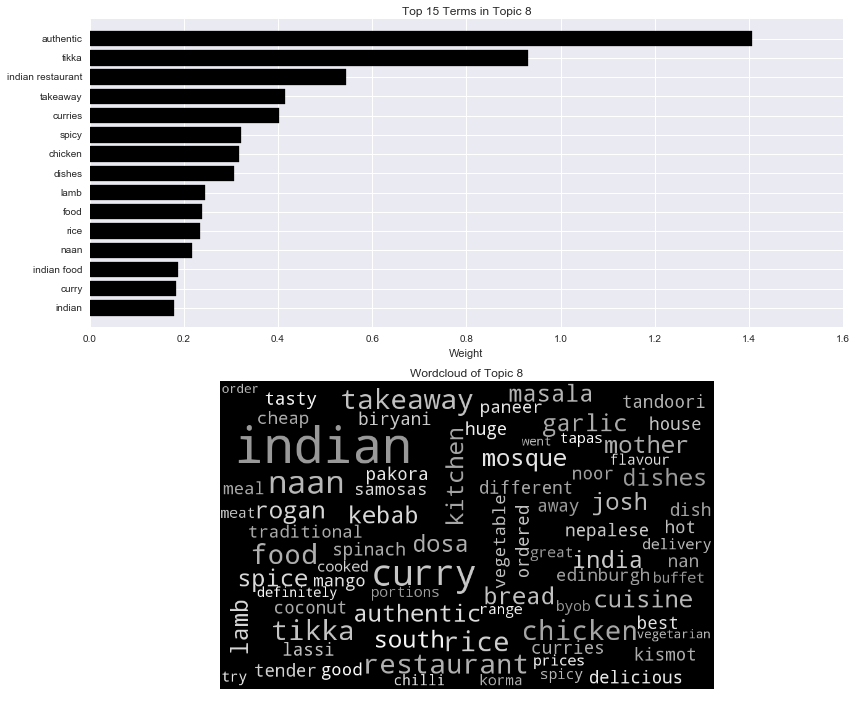


 Topic 9: 

Percentage of Words: 18.70%



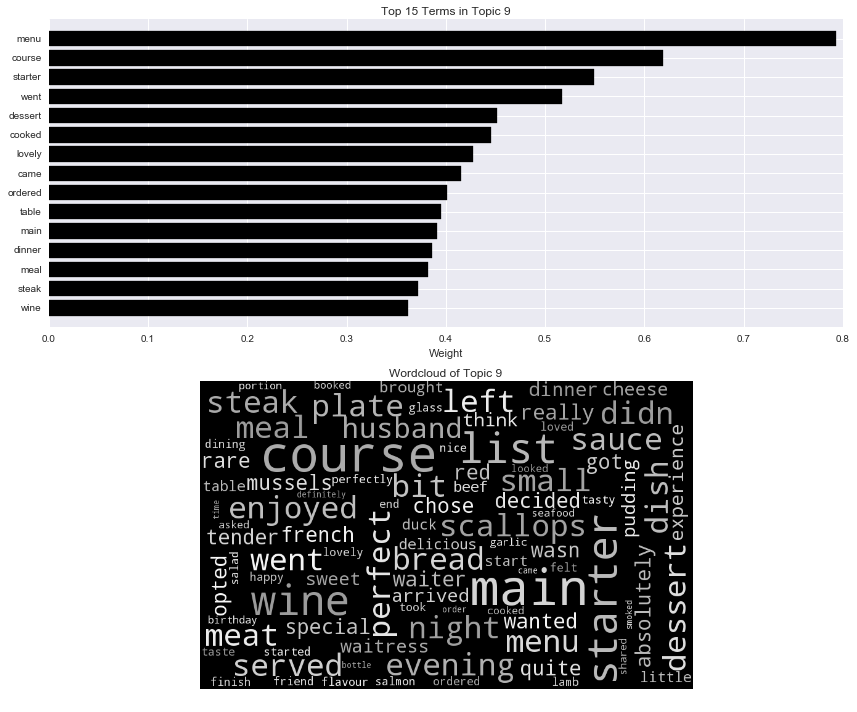


 Topic 10: 

Percentage of Words: 12.54%



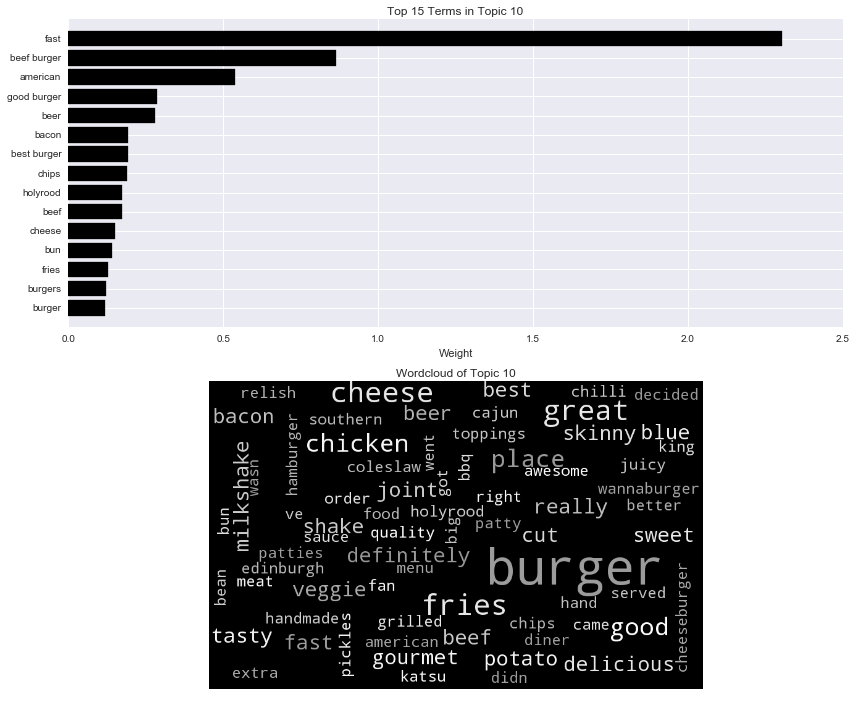


 Topic 11: 

Percentage of Words: 9.54%



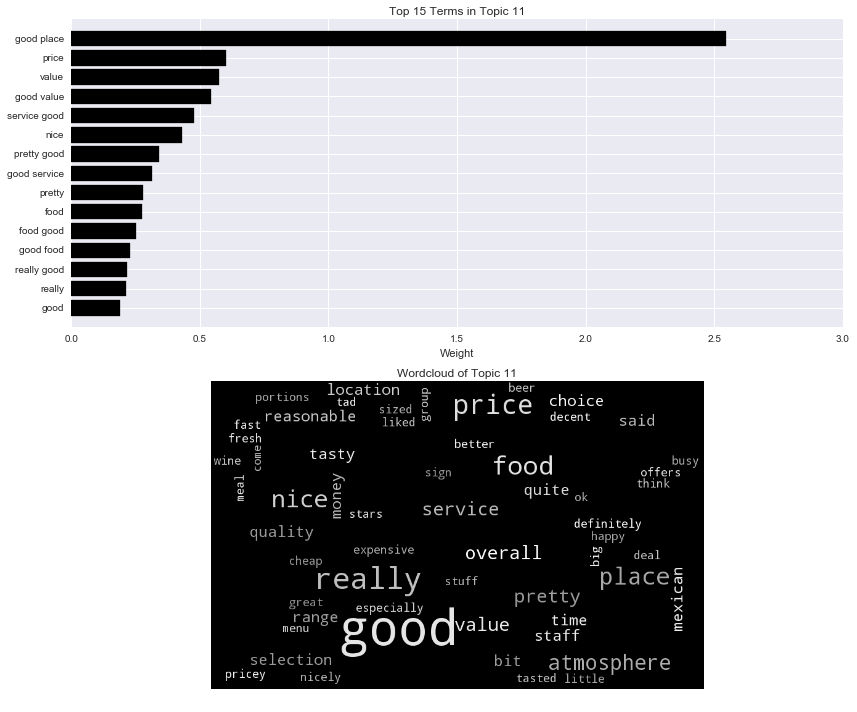


 Topic 12: 

Percentage of Words: 13.29%



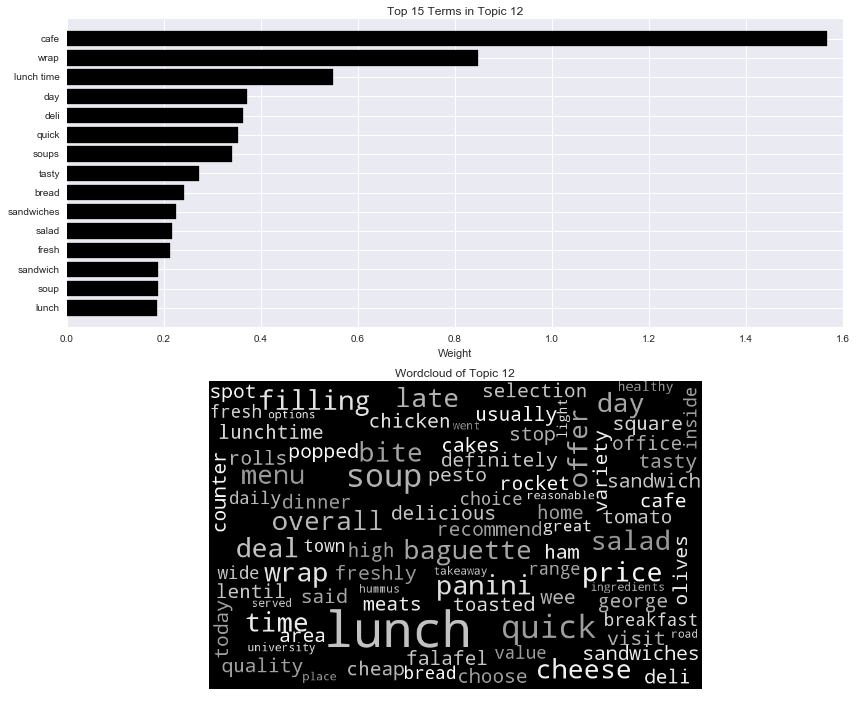


 Topic 13: 

Percentage of Words: 12.03%



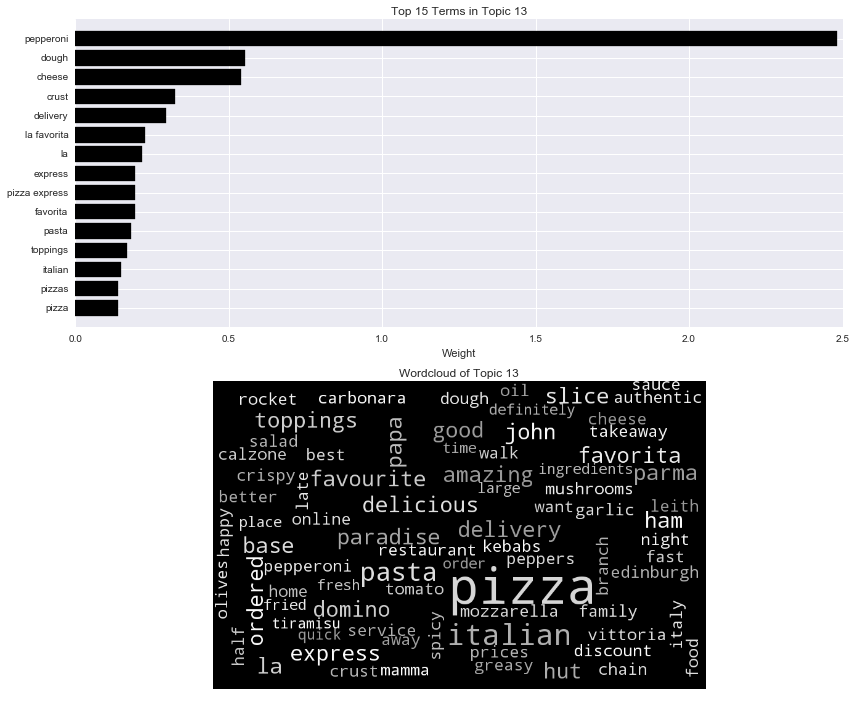


 Topic 14: 

Percentage of Words: 13.32%



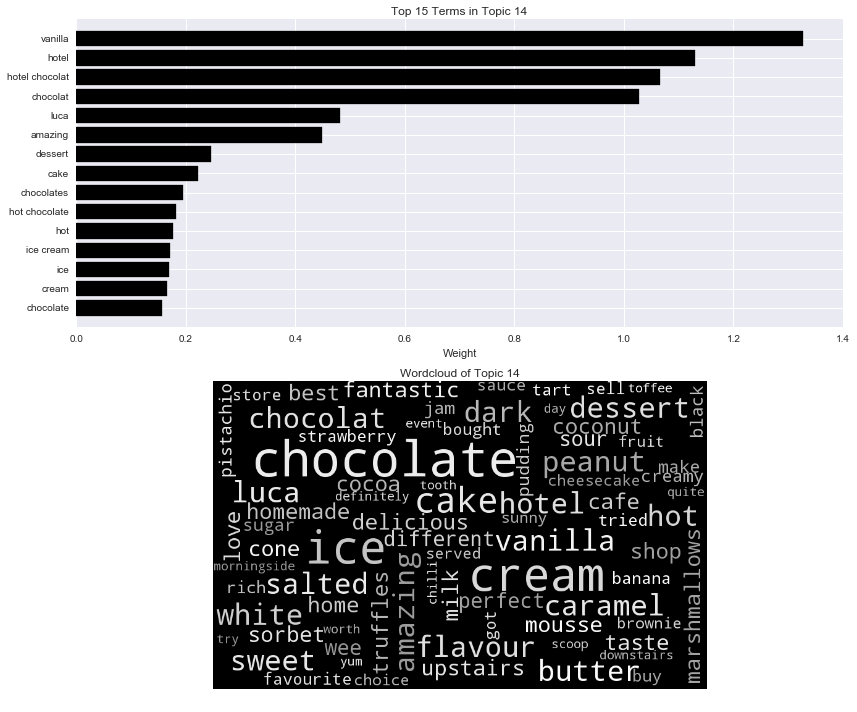


 Topic 15: 

Percentage of Words: 12.99%



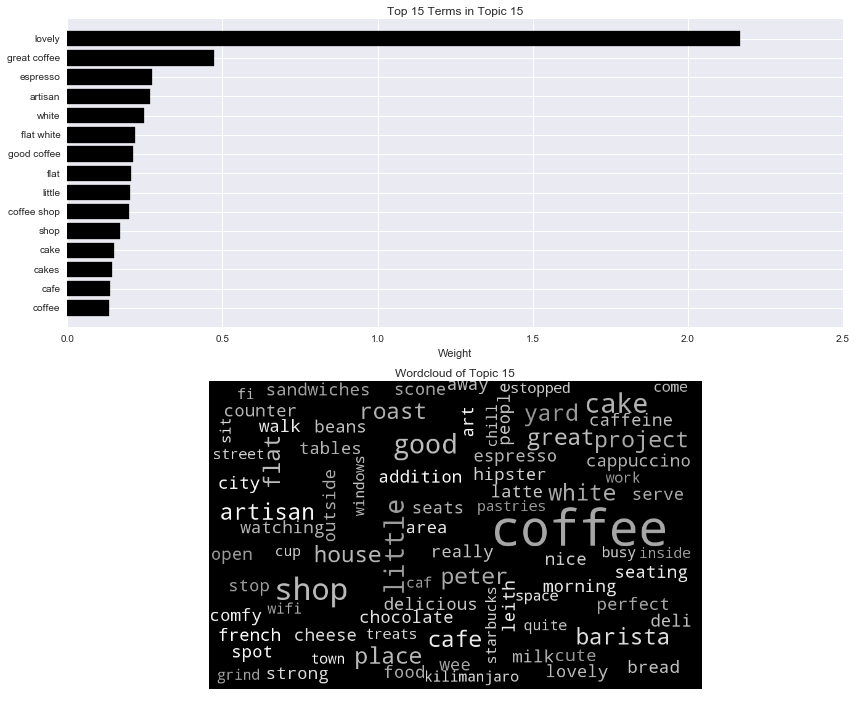


 Topic 16: 

Percentage of Words: 10.70%



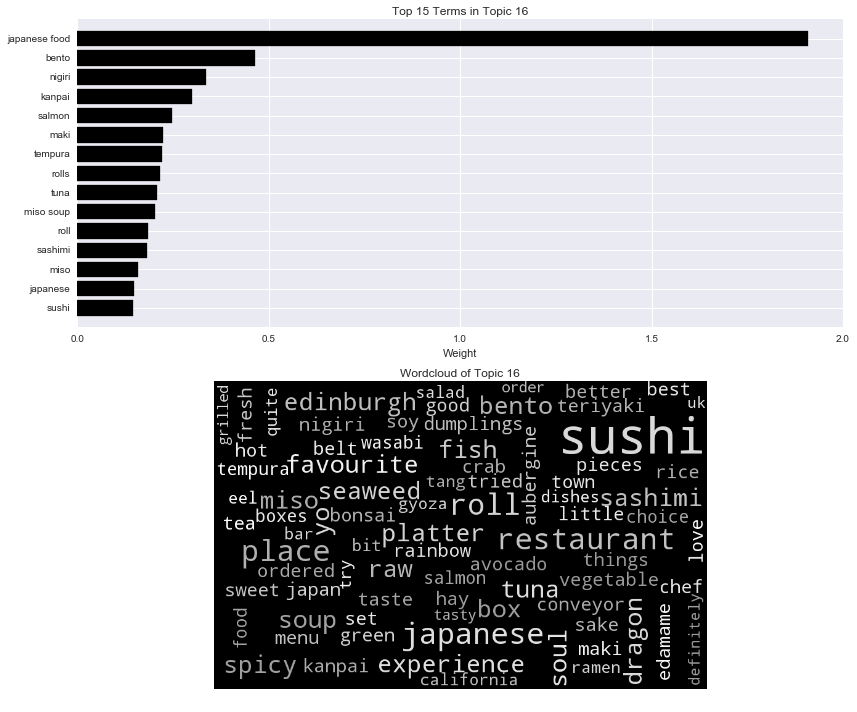


 Topic 17: 

Percentage of Words: 12.88%



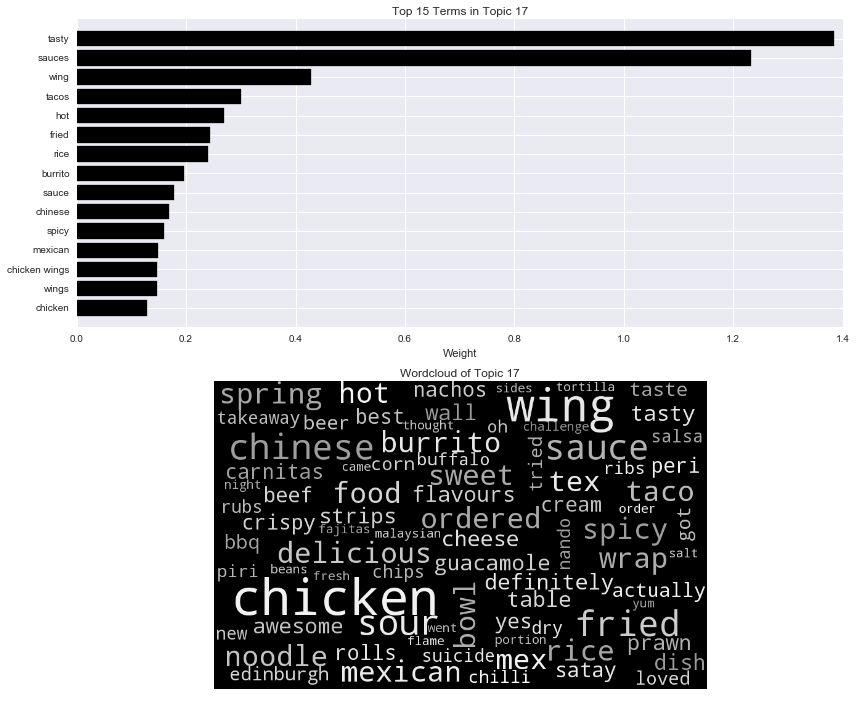


 Topic 18: 

Percentage of Words: 8.95%



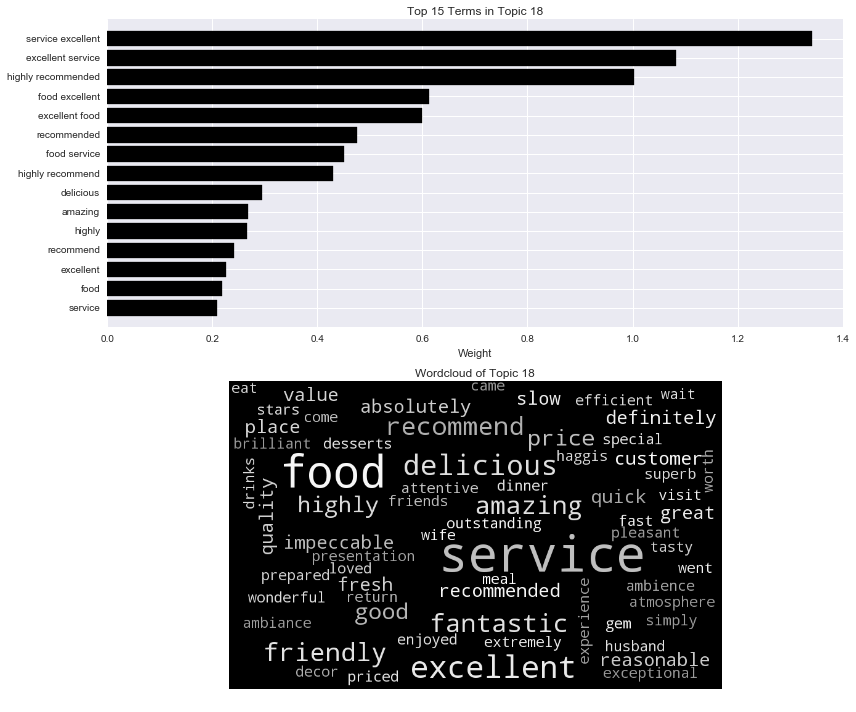


 Topic 19: 

Percentage of Words: 12.65%



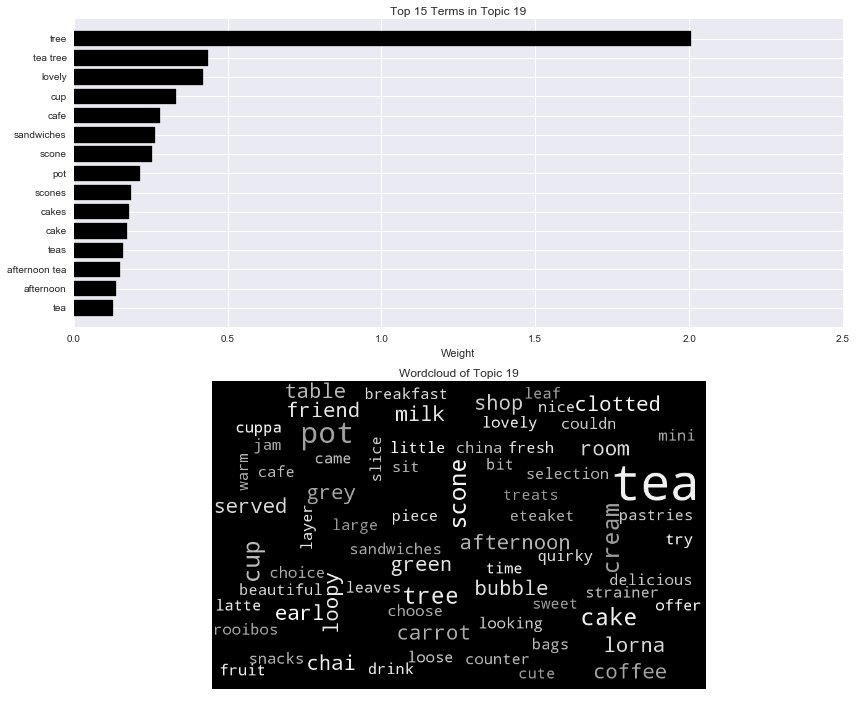


 Topic 20: 

Percentage of Words: 12.86%



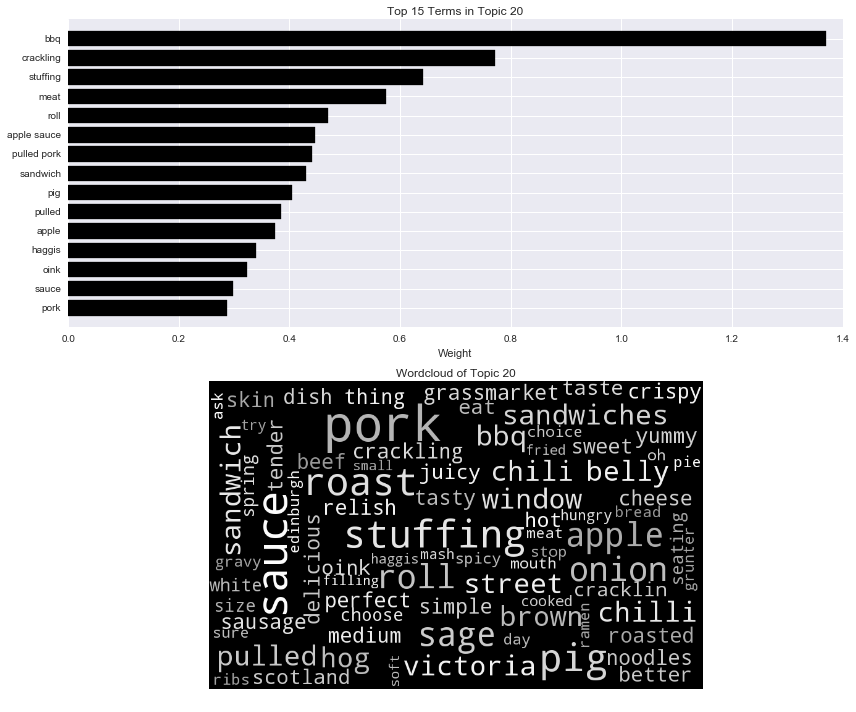


 Topic 21: 

Percentage of Words: 5.92%



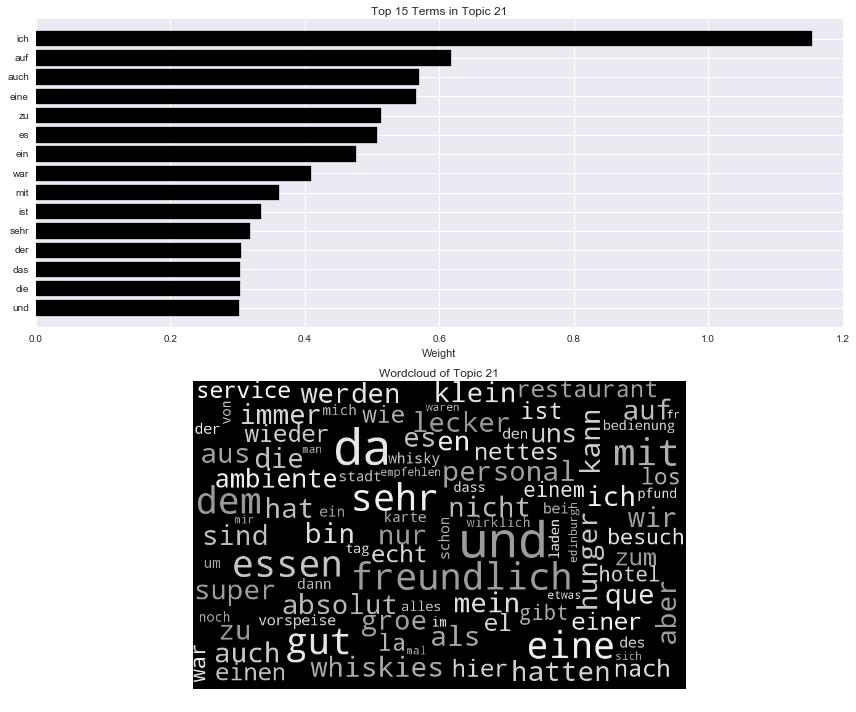


 Topic 22: 

Percentage of Words: 8.91%



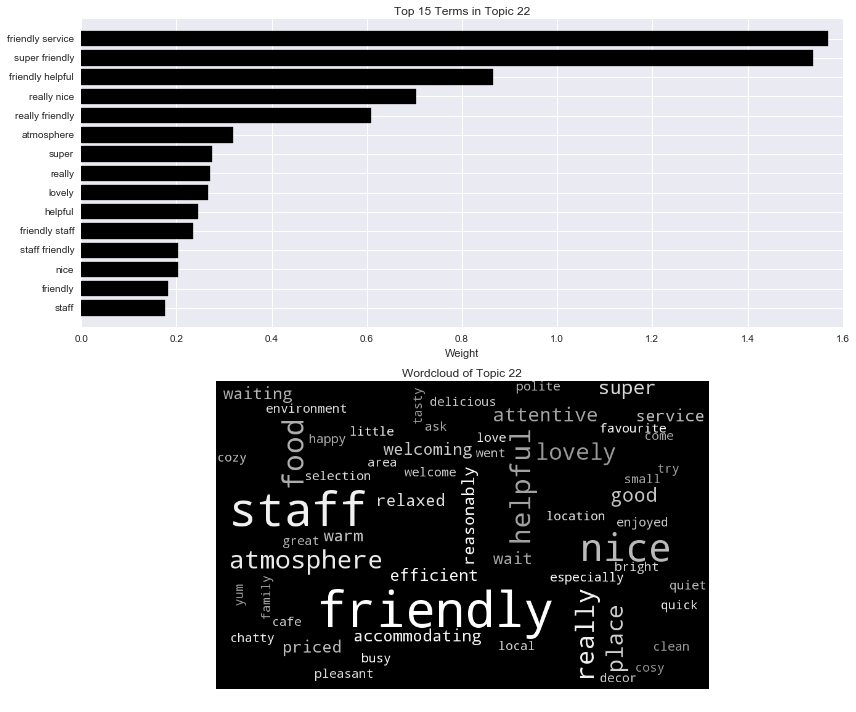


 Topic 23: 

Percentage of Words: 11.59%



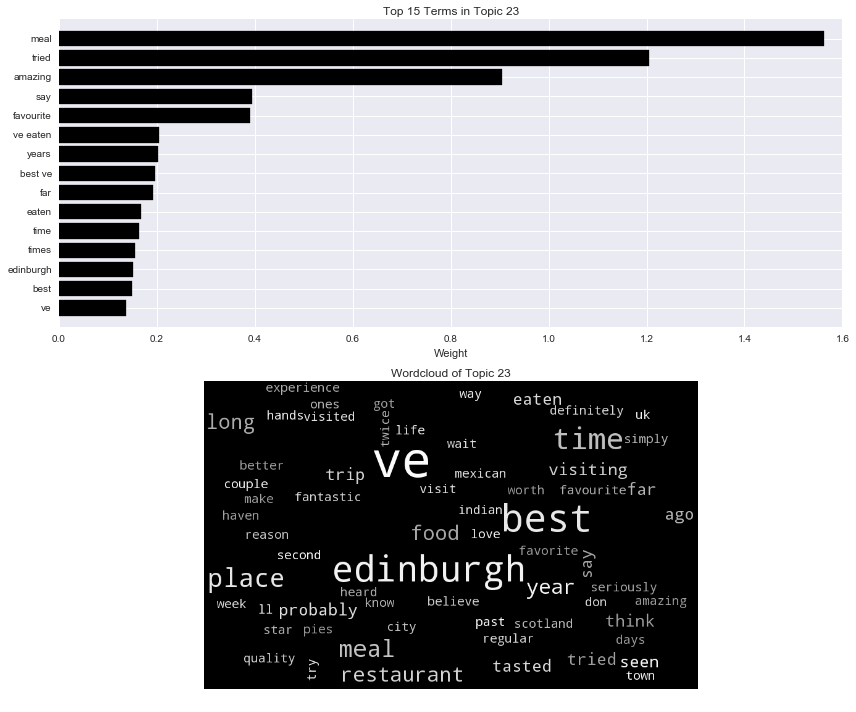


 Topic 24: 

Percentage of Words: 11.45%



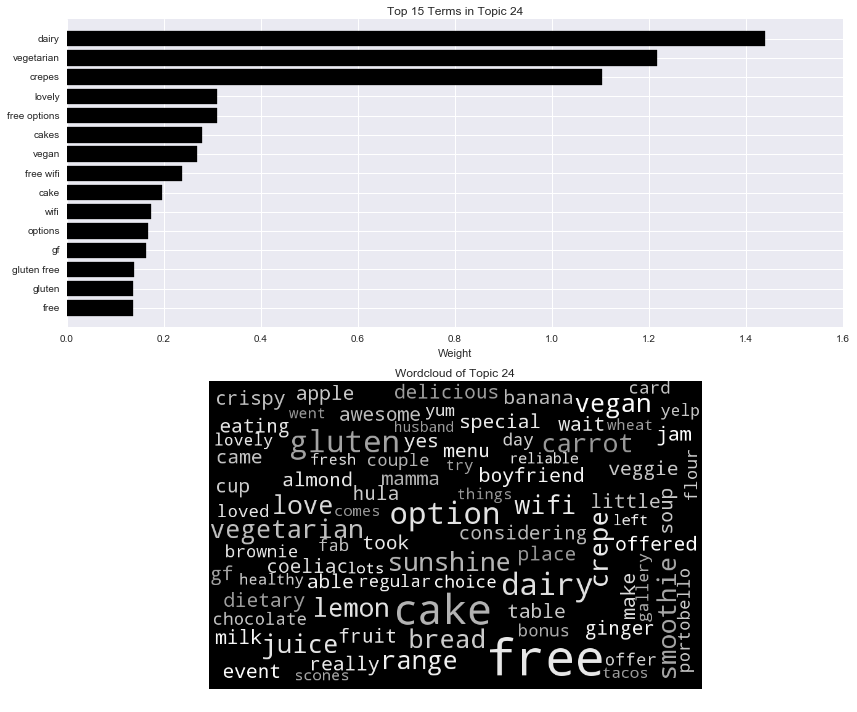


 Topic 25: 

Percentage of Words: 11.86%



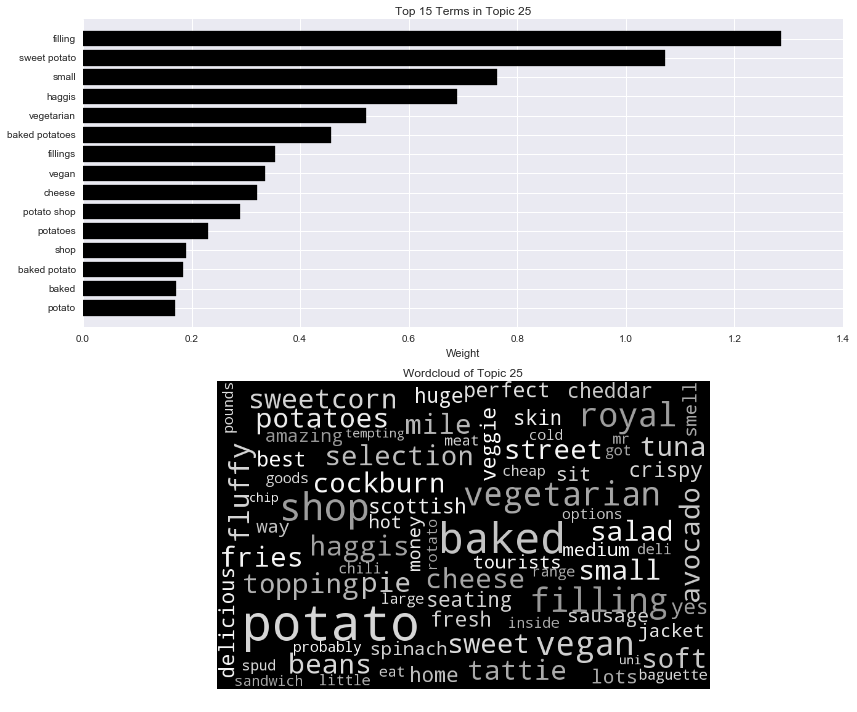

In [20]:
TopTermsByTopic(nmfmodel_good, features_good, 100)

This section summarises topics discovered by NMF model from good reviews text. An attempt to interpret the contents of each topic was made, keywords in each topic were manually examined and a description of each topic was then assigned.

In [27]:
data_good = {'Index of Topics':['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8'
                           ,'Topic 9','Topic 10','Topic 11','Topic 12','Topic 13','Topic 14','Topic 15'
                           ,'Topic 16','Topic 17','Topic 18','Topic 19','Topic 20',
                            'Topic 21','Topic 22','Topic 23','Topic 24','Topic 25']
        ,'Type of Topics':['Unknown Topic','Good Quality foods','Good Place and Atmosphere',
                           'Good Bars and Pubs', 'Good Scottish Breakfast',
                           'Good Fish and Chips with nice peas','Good Thai Foods with decent prawn',
                           'Good Indian Foods', 'Good Menu','Good Beef Burger with decent sweet potatoes',
                           'Good Price and Value','Good Sandwiches', 'Good Italian Foods (Pasta and Pizza)',
                           'Good chocolates and ice creams','Good Coffee Shops with Nice Artisan and Expresso',
                           'Good Japanese foods (Bento,Nigiri,Kanpai)','Good Mexican Burritos and Tacos',
                           'Excellent Services', 'Good Afternoon Tea', 'Good BBQ Shops (crackling pork, haggis)',
                           'Unknown German Reviews', 'Friendly Staff','Good Foods', 'Good Vegetarian Restaurants',
                           'Good Potato Shops'
                           ]
       } 

topic_table_good = pd.DataFrame(data_good)
display(topic_table_good)

Index of Topics                                    Type of Topics
0          Topic 1                                     Unknown Topic
1          Topic 2                                Good Quality foods
2          Topic 3                         Good Place and Atmosphere
3          Topic 4                                Good Bars and Pubs
4          Topic 5                           Good Scottish Breakfast
5          Topic 6                Good Fish and Chips with nice peas
6          Topic 7                 Good Thai Foods with decent prawn
7          Topic 8                                 Good Indian Foods
8          Topic 9                                         Good Menu
9         Topic 10       Good Beef Burger with decent sweet potatoes
10        Topic 11                              Good Price and Value
11        Topic 12                                   Good Sandwiches
12        Topic 13              Good Italian Foods (Pasta and Pizza)
13        Topic 14                    Good chocolates and ice creams
14        Topic 15  Good Coffee Shops with Nice Artisan and Expresso
15        Topic 16         Good Japanese foods (Bento,Nigiri,Kanpai)
16        Topic 17                   Good Mexican Burritos and Tacos
17        Topic 18                                Excellent Services
18        Topic 19                                Good Afternoon Tea
19        Topic 20           Good BBQ Shops (crackling pork, haggis)
20        Topic 21                            Unknown German Reviews
21        Topic 22                                    Friendly Staff
22        Topic 23                                        Good Foods
23        Topic 24                       Good Vegetarian Restaurants
24        Topic 25                                 Good Potato Shops

### 4.6 Recommendation

The topics extracted by NMF model from both good and bad reviews were used to make the recommendation below.

**Opportunities to explore when opening a restaurant in Edinburgh:**
1. Customers are not satisfied with the type of batter for fish and chips in Edinburgh, which was complained to be too soggy. (Bad Review Topic 5)
2. Customers are also not particularly happy with chicken dishes in Edinburgh. (Bad Review Topic 3)
3. Foods and drinks at a cafe where JK Rowling visited were not satisfying and received a lot of complaints. (Bad Review Topic 10)
4. Sweet and sour chickens are not satisfying at chinese restaurants in Edinburgh. (Bad Review Topic 13)
5. Thai Foods for lunch are not good (Bad Review Topic 25)
6. Current noodle shops in Edinburgh are bad (Bad Review Topic 21)
7. Good atmosphere, location, friendly staff and price-to-value could enhance customer experience (Good Review Topics 2,3,11 and 22)


**Areas to avoid and improve when opening a restaurant in Edinburgh:**

1.  Customers complained about bad services from rude and unfriendly waiter and waitress (Bad Review Topics 1 and 12)
2. Customers complained about long wait (Bad Review Topic 8)
3. Customers complained about room temperature (Bad Review Topic 24)
4. Customers complained about bars and pubs that are too quiet (Bad Review Topic 16)

For sectors where businesses are doing very well would also mean new entrants could face a big challenge to enter these sectors.

5. Good Review Topic 4 appeared in 16.57% of reviews, that implies bars and pubs are providing very good services in Edinburgh.
6. Good Review Topic 15 appeared in 13.32% of reviews, that means current coffee shops are providing very good coffees and services.
7. BBQ shops are doing very well in Edinburgh. (Good Review Topic 20)
8. Potato shops are doing very well in Edinburgh. (Good Review Topic 25)

## 5. Analysis - Price, Volume and Revenue (Jon Leung)

## 6. Managerial Recommendations

## 7. Reference

1. D. Cai, X. He, J. Han, and T. S. Huang. Graph regularized nonnegative matrix factorization
for data representation. IEEE Transactions on Pattern Analysis and Machine Intelligence
(TPAMI), 33(8):1548–1560, 2011.

2. J. Choo, C. Lee, C. K. Reddy, and H. Park. UTOPIAN: User-driven topic modeling based on
interactive nonnegative matrix factorization. IEEE Transactions on Visualization and Computer
Graphics (TVCG), 19(12):1992–2001, 2013

3. A. Cichocki, R. Zdunek, A. H. Phan, and S. Amari. Nonnegative Matrix and Tensor Factorizations:
Applications to Exploratory Multi-Way Data Analysis and Blind Source Separation.
Wiley, 2009.